In [1]:
#import 
import pymysql
import pymssql
import sqlalchemy
from sqlalchemy import create_engine

import re

import socket

import datetime
import pandas as pd
import numpy as np
import time

from snapshot_selenium import snapshot
from pyecharts.render import make_snapshot

import pyecharts.options as opts
from pyecharts.charts import Line
from pyecharts.charts import Bar
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

from reportlab.graphics.shapes import Drawing, Circle
from reportlab.lib import colors
from reportlab.lib.colors import HexColor
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import ParagraphStyle
from reportlab.lib.units import inch
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfgen.canvas import Canvas
from reportlab.graphics.shapes import Image as DrawingImage
from reportlab.lib.styles import getSampleStyleSheet,ParagraphStyle
from reportlab.platypus import SimpleDocTemplate,Paragraph,Spacer,Image,Table,TableStyle,Frame,ListFlowable,ListItem,PageBreak
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.colors import CMYKColor

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

import warnings;warnings.simplefilter('ignore')

import requests

import zhconv


In [2]:
# 字体页面, 段落格式
msyh = "msyh"
msyhbd = "msyhbd"
song = "simsun"
pdfmetrics.registerFont(TTFont(song, "simsun.ttc"))
pdfmetrics.registerFont(TTFont(msyh, "msyh.ttc"))
pdfmetrics.registerFont(TTFont(msyhbd, "msyhbd.ttc"))

PAGE_HEIGHT = A4[1]
PAGE_WIDTH = A4[0]

# 段落格式
titleStyle = ParagraphStyle(
    name="titleStyle",
    alignment=1,
    fontName=msyhbd,
    fontSize=10,
    textColor=colors.black,
    backColor=HexColor(0xF2EEE9),
    borderPadding=(5, 5))

# 文本格式
styles = getSampleStyleSheet()
styles.add(ParagraphStyle(name='txt', leftIndent=0,rightIndent=-50,fontName="msyh",fontSize=10,textColor=colors.black,bulletFontSize=12,
        bulletIndent=-50,bulletAnchor ='start',bulletFontName = 'Symbol'))
styles.add(ParagraphStyle(name='des', leftIndent=0,rightIndent=-50,fontName="msyh",fontSize=8,textColor=colors.black,bulletFontSize=12,
        bulletIndent=-50,bulletAnchor ='start',bulletFontName = 'Symbol'))

In [3]:
# EIA
def text_eia_sim(m_c,feature):
    oil_pred= m_c['oil_pred']
    oil_chg= m_c['oil_chg']
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']
    
    
    # Descriptive text
    def more_less(num):
        if num>0:
            text = '增加'
        else:
            text = '减少'
        return text
    def up_down(num):
        if num>0:
            text = '上涨'
        else:
            text = '下跌'
        return text
    def consistency(s1,s2):
        if s1 *s2 >0 :
            text= '一致'
        else:
            text= '相反'
        return text
    def long_short(signal):
        if signal==1:
            text= '做多'
        else:
            text= '做空'
        return text
    def buy_sell(signal):
        if signal==1:
            text= '买入'
        else:
            text= '卖出'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格强势看涨。"
        elif proba < 0.3:
            text = f"右图显示看跌的置信度为{(1 - proba)*100}%，可认为模型预测价格强势看跌。"
        else:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格变动幅度不大。"
        return text 
    def profit_loss(num):
        if num>0:
            text= '盈利'
        else:
            text= '亏损'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= '，下单延迟导致亏损。'
        else:
            text= '。'
        return text

#     报告主体文字
    page_font= 'Goldriven出品 本报告生成于'+datetime.date.today().isoformat()
    heading= deal.model_name+'模型交易汇总'
    title1= '市场变化'
    title2= '模型参数'
    title3= '模型运作'
    title4= '实际交易'

#     段内文字
    market = f'''<para><br/>EIA原油库存预期{more_less(oil_pred)}{round(abs(oil_pred)/10,1)}万桶，实际公布{more_less(oil_chg)}{round(abs(oil_chg)/10,1)}万桶。</para>'''
    impt = f'''<para><br/>特征对标签预测均有较高的重要性；其中，特征A的重要性最为显著。</para>'''
    corrpie = f'''<para><br/>左图显示特征之间呈现很强的相关性，数据可能处于潜在的低维流形上，可通过降维方法对特征进行
                  <br/>进一步筛选/提取；
                       <br/>{pie_des(proba)}</para>'''
    model = f'''<para><br/>{deal.trade_time} 数据发布后WTI原油价格走势为{up_down(real_trend)}；
                      <br/>{time1} 数据程序已成功获取到彭博数据，模型计算得到的信号为{signal}（即{long_short(signal)}原油）；
                      <br/>{time2} 模型结束运算并发送{long_short(signal)}信号，与原油价格走势{consistency(signal,real_trend)}。</para>'''
    trade = f'''<para><br/>{time_convert(open_time)} 以${open_price}进行{buy_sell(signal)}，交易数量为{int(volume/trading_hand)}手；
                      <br/>{time_convert(closed_time)} 在${closed_price}平仓{order_delay(signal,real_trend,profit)}
                      <br/>本次交易投入成本（即保证金）${cost}，{profit_loss(profit)}${profit}，收益率为{return_rate}%；
                      <br/>账户中原余额${balance}，现余额${new_balance}，总收益率为{return_rate_account}%。</para>'''
                        
    des1= '''<para><br/>原油——库存变化</para>'''
    des2= '''<para><br/>汽油——库存变化</para>'''
    des3= '''<para><br/>精炼油——库存变化</para>'''
    des4= '''<para><br/>WTI原油——价格变化</para>'''
    
#     图表名字
    pie1= '买入'
    pie2= '卖出'
    wti_price= 'WTI原油价格'
    cmdusd= '原油价格变动'
    txt_open= '开仓'
    txt_closed= '平仓'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade","des1","des2","des3","des4",
    "pie1","pie2","wti_price","cmdusd","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,des1,des2,des3,des4,
    pie1,pie2,wti_price,cmdusd,txt_open,txt_closed]
    
    return turn_dict(name,var)

def text_eia_eng(m_c,feature):
    oil_pred= m_c['oil_pred']
    oil_chg= m_c['oil_chg']
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']

    def more_less(num):
        if num>0:
            text = 'increase'
        else:
            text = 'decline'
        return text
    def more_less_non(num):
        if num>0:
            text = 'an increase'
        else:
            text = 'a decline'
        return text
    def up_down(num):
        if num>0:
            text = 'upward'
        else:
            text = 'downward'
        return text
    def consistency(s1,s2):
        if s1 *s2 >0 :
            text= 'consistent'
        else:
            text= 'inconsistent'
        return text
    def long_short(signal):
        if signal==1:
            text= 'long'
        else:
            text= 'short'
        return text
    def buy_sell(signal):
        if signal==1:
            text= 'bought'
        else:
            text= 'sold'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"The figure on the right shows that the confidence level of bullishness is {proba*100}%, which means that model predicts the price will be strongly bullish."
        elif proba < 0.3:
            text = f"The figure on the right shows that the confidence level of bearishness is {(1 - proba)*100}%, which means that model predicts the price will be strongly bearish."
        else:
            text = f"The figure on the right shows that the confidence level is {proba*100}%, which means that model predicts little price volatility."
        return text 
    def profit_loss(num):
        if num>0:
            text = 'profit'
        else:
            text = 'loss'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= ' while placing a delayed order led to the loss.'
        else:
            text= '.'
        return text
    
#     报告主体文字
    page_font= 'Report Generated on '+datetime.date.today().isoformat()+' by Goldriven'
    heading= deal.model_name+' Model Trading Summary'
    title1= 'Official Release'
    title2= 'Model Parameters'
    title3= 'Model Operating Details'
    title4= 'Real-time Transaction'

    
#     段内文字
    market = f'''<para><br/>U.S. Crude Oil Inventories is expected to {more_less(oil_pred)} by {round(abs(oil_pred)/1000,3)}M barrels,<br/>and the actual release is {more_less_non(oil_chg)} of {round(abs(oil_chg)/1000,3)}M barrels.</para>'''
    impt = f'''<para><br/>Most features have high importance for the label prediction.<br/>Meanwhile, feature A contributes the most.</para>'''
    corrpie = f'''<para><br/>The figure on the left shows that there is a strong correlation between features,<br/>indicating datas may lie on a potentially low-dimensional manifold,<br/>and features can be further filtered/extracted by dimensionality reduction methods;
                       <br/>
                       <br/>{pie_des(proba)}</para>'''
    model = f'''<para><br/>{deal.trade_time} After the release, crude oil price is trending {up_down(real_trend)};
                      <br/>{time1} {deal.model_name} model acquired BloomBerg datas and started analyzing.<br/>The output result is {signal}(that is, to {long_short(signal)} crude oil);
                      <br/>{time2} {deal.model_name} model finished computing and sent {long_short(signal)} signal, which is {consistency(signal,real_trend)} with<br/>the market reaction.</para>'''
    trade = f'''<para><br/>{time_convert(open_time)} We {buy_sell(signal)} at ${open_price}, with the trading volume of {int(volume/trading_hand)}lots;
                      <br/>{time_convert(closed_time)} We closed the positon at ${closed_price}{order_delay(signal,real_trend,profit)}
                      <br/>The cost(initial margin) of this transaction is ${cost}, <br/>with the {profit_loss(profit)} of ${profit}, and with the return rate of {return_rate}%.
                      <br/>The original balance of the account is ${balance},<br/> and the current balance is ${new_balance}, with the total return rate of {return_rate_account}%.</para>'''
    des1= '''<para><br/>Crude Oil Inventories - histogram</para>'''
    des2= '''<para><br/>Gasoline Inventories - histogram</para>'''
    des3= '''<para><br/>Distillates Stocks - histogram</para>'''
    des4= '''<para><br/>Crude Oil WTI Price</para>'''
    
#     图表名字
    pie1= 'Long'
    pie2= 'Short'
    wti_price= 'Crude Oil WTI Price'
    cmdusd= 'Crude Oil Price'
    txt_open= 'Open'
    txt_closed= 'Closed'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade","des1","des2","des3","des4",
    "pie1","pie2","wti_price","cmdusd","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,des1,des2,des3,des4,
    pie1,pie2,wti_price,cmdusd,txt_open,txt_closed]
    
    return turn_dict(name,var)

def plot_eia(m_c,feature,text,language):
    from reportlab.lib import colors
    plot_econ= m_c['plot_econ']
    proba= feature['proba']
    txt_wti_price= text['wti_price']
    plot_ticks= feature['plot_ticks']
    txt_cmdusd= text['cmdusd']
    open_pt= feature['open_pt']
    closed_pt= feature['closed_pt']
    txt_open= text['txt_open']
    txt_closed= text['txt_closed']
    open_price= feature['open_price']
    closed_price= feature['closed_price']
    real_trend= feature['real_trend']
    txt_pie1= text['pie1']
    txt_pie2= text['pie2']
    if real_trend>0:
        plot_min= float(open_price)-0.6
    else:
        plot_min= float(closed_price)-0.6
    
    def bar_oil():
        l1 = plot_econ.date.tolist()
        l2 = plot_econ.oil_chg.tolist()
        bar_oil = (
            Bar()
            .add_xaxis(l1)
            .add_yaxis('', l2)
            .set_global_opts(title_opts=opts.TitleOpts(title="", 
                                                       title_textstyle_opts=opts.TextStyleOpts(font_weight="bolder",font_size=30)
                                                      )
                            )
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
            )
        return bar_oil
    def bar_gasoline():
        l1 = plot_econ.date.tolist()
        l2 = plot_econ.gasoline_chg.tolist()
        bar_gasoline = (
            Bar()
            .add_xaxis(l1)
            .add_yaxis('', l2)
            .set_global_opts(title_opts=opts.TitleOpts(title="", 
                                                    title_textstyle_opts=opts.TextStyleOpts(font_weight="bolder",font_size=30)
                                                      )
                            )
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))    
            )
        return bar_gasoline
    def bar_refined():
        l1 = plot_econ.date.tolist()
        l2 = plot_econ.refined_chg.tolist()
        bar_refined = (
            Bar()
            .add_xaxis(l1)
            .add_yaxis('', l2)
            .set_global_opts(title_opts=opts.TitleOpts(title="", 
                                                       title_textstyle_opts=opts.TextStyleOpts(font_weight="bolder",font_size=30)
                                                      )
                            )
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
            )
        return bar_refined
    def line_wti_price():
        wti_his = pd.read_csv('EIA/WTI_price_his.csv')
        l1 = wti_his.date.tolist()
        l2 = wti_his.WTI_price.tolist()
        wti_price = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_wti_price}", l2,is_smooth=True, areastyle_opts=opts.AreaStyleOpts(opacity=0.3))
            .set_global_opts(title_opts=opts.TitleOpts(title=""))
            .set_series_opts(
                label_opts=opts.LabelOpts(is_show=False)
            )
        )
        return wti_price  
    def cmdusd_eia():
        l1 = plot_ticks.display_time.tolist()
        l2 = plot_ticks.average.tolist()
        price = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_cmdusd}", l2, is_smooth=True, areastyle_opts=opts.AreaStyleOpts(opacity=0.3))
            .set_global_opts(title_opts=opts.TitleOpts(title=""))
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                             markpoint_opts=opts.MarkPointOpts(
                                 data=[
                                     opts.MarkPointItem(coord=open_pt, value=f"{txt_open}"),
                                     opts.MarkPointItem(coord=closed_pt, value=f"{txt_closed}")
                                 ])
                            )
            .set_global_opts(yaxis_opts=opts.AxisOpts(min_=plot_min))
        )
        return price
    
    bar_oil().render()
    js_to_local()
    make_snapshot(snapshot,'render_updated.html', f"EIA/EIA_{deal.trade_date_index}/bar_oil.png")
    bar_gasoline().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"EIA/EIA_{deal.trade_date_index}/bar_gasoline.png")
    bar_refined().render()
    js_to_local()
    make_snapshot(snapshot,'render_updated.html', f"EIA/EIA_{deal.trade_date_index}/bar_refined.png")
    line_wti_price().render()
    js_to_local()             
    make_snapshot(snapshot,'render_updated.html' , f"EIA/EIA_{deal.trade_date_index}/{language}_wti_price.png")
    cmdusd_eia().render()
    js_to_local()
    make_snapshot(snapshot,'render_updated.html' , f"EIA/EIA_{deal.trade_date_index}/{language}_actual_price.png")
    
    colors = sns.color_palette('pastel')
    fig = plt.figure(figsize=(10, 10))
    patches,l_text,p_text = plt.pie([proba, 1-proba], labels=[f'{txt_pie1}', f'{txt_pie2}'], colors=colors, autopct='%1.1f%%')
    for t in l_text:
        t.set_size(30)
    for t in p_text:
        t.set_size(30)
    plt.savefig(f"EIA/EIA_{deal.trade_date_index}/{language}_model_pie.png")
    
def pdf_eia(text,language):
    ## 文档
    from reportlab.lib import colors
    title1= text['title1']
    txt_market= text['market']
    txt_des1= text['des1']
    txt_des2= text['des2']
    txt_des3= text['des3']
    txt_des4= text['des4']
    title2= text['title2']
    txt_corrpie= text['corrpie']
    txt_impt= text['impt']
    title3= text['title3']
    txt_model= text['model']
    title4= text['title4']
    txt_trade= text['trade']
    txt_heading= text['heading']
    txt_page_font= text['page_font']

    doc = SimpleDocTemplate(f"output/{deal.report_index}_{language}.pdf")
    Story = [Spacer(1, 0.5 * inch)]
    # 段落
    Story.append(Paragraph(f"{title1}", titleStyle))
    Story.append(Paragraph(txt_market,styles["txt"])) 
    Story.append(Paragraph(txt_des1,styles["des"])) 
    Story.append(Image(f"EIA/EIA_{deal.trade_date_index}/bar_oil.png", 6 * inch, 2.3 * inch))
    Story.append(Paragraph(txt_des2,styles["des"])) 
    Story.append(Image(f"EIA/EIA_{deal.trade_date_index}/bar_gasoline.png", 6 * inch, 2.3* inch))
    Story.append(Paragraph(txt_des3,styles["des"])) 
    Story.append(Image(f"EIA/EIA_{deal.trade_date_index}/bar_refined.png", 6 * inch, 2.3 * inch))
    Story.append(PageBreak())
    Story.append(Paragraph(txt_des4,styles["des"])) 
    Story.append(Image(f"EIA/EIA_{deal.trade_date_index}/{language}_wti_price.png", 6 * inch, 3 * inch))
    Story.append(Spacer(1, 0.6 * inch))

    Story.append(Paragraph(f"{title2}", titleStyle))
    Story.append(Spacer(1, 0.4 * inch))
    d = Drawing()
    d.add(DrawingImage(0, 0, 240, 200, "EIA/model_corr.png"))
    d.add(DrawingImage(230, -10, 220, 220, f"EIA/EIA_{deal.trade_date_index}/{language}_model_pie.png"))
    Story.append(d)
    Story.append(Spacer(1, 0.1 * inch))
    Story.append(Paragraph(txt_corrpie,styles["txt"]))
    Story.append(PageBreak())
    Story.append(Image("EIA/model_impt.png", 6 * inch, 3 * inch))
    Story.append(Paragraph(txt_impt,styles["txt"]))
    Story.append(Spacer(1, 0.3 * inch))

    Story.append(Paragraph(f"{title3}", titleStyle))
    Story.append(Paragraph(txt_model,styles["txt"])) 
    Story.append(Spacer(1, 0.3 * inch))

    Story.append(Paragraph(f"{title4}", titleStyle))
    Story.append(Spacer(1, 0.2 * inch))
    Story.append(Image(f"EIA/EIA_{deal.trade_date_index}/{language}_actual_price.png", 6 * inch, 3 * inch))
    Story.append(Paragraph(txt_trade,styles["txt"])) 
    
        # 页脚格式
    def DrawPageInfo(c: Canvas):
        # 边框颜色
        c.setStrokeColor(colors.dimgrey)
        # 线条
        c.line(30, PAGE_HEIGHT - 790, 570, PAGE_HEIGHT - 790)
        # 页脚文字
        c.setFont(song, 8)
        c.setFillColor(colors.black)
        c.drawString(30, PAGE_HEIGHT - 810, f"{txt_page_font}")  
    # 页脚
    def myLaterPages(c: Canvas, doc):
        c.saveState()
        DrawPageInfo(c)
        c.restoreState()
    # 标题
    def myFirstPage(c: Canvas, doc):
        c.saveState()
        # 填充色
        c.setFillColor(colors.black)
        # 字体大小
        c.setFont(msyhbd, 30)
        # 居中标题文本
        c.drawCentredString(300, PAGE_HEIGHT - 80, f"{txt_heading}")

        DrawPageInfo(c)
        c.restoreState()


    # 保存文档

    doc.build(Story, onFirstPage=myFirstPage, onLaterPages=myLaterPages)

In [4]:
# USCPI
def text_uscpi_sim(m_c,feature):
    ccpi_psnt= m_c['ccpi_psnt']
    ccpi_pred= m_c['ccpi_pred']
    cpi_psnt= m_c['cpi_psnt']
    cpi_pred= m_c['cpi_pred']
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']
    
        # Descriptive text
    def more_less(num):
        if num>0:
            text = '增加'
        else:
            text = '减少'
        return text
    def up_down(num):
        if num>0:
            text = '上涨'
        else:
            text = '下跌'
        return text
    def consistency(s1,s2):
        if s1 *s2 >0 :
            text= '一致'
        else:
            text= '相反'
        return text
    def long_short(signal):
        if signal==1:
            text= '做多'
        else:
            text= '做空'
        return text
    def buy_sell(signal):
        if signal==1:
            text= '买入'
        else:
            text= '卖出'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格强势看涨。"
        elif proba < 0.3:
            text = f"右图显示看跌的置信度为{(1 - proba)*100}%，可认为模型预测价格强势看跌。"
        else:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格变动幅度不大。"
        return text 
    def profit_loss(num):
        if num>0:
            text = '盈利'
        else:
            text = '亏损'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= '，下单延迟导致亏损。'
        else:
            text= '。'
        return text
    
    
#     报告主体文字
    page_font= 'Goldriven出品 本报告生成于'+datetime.date.today().isoformat()
    heading= deal.model_name+'模型交易汇总'
    title1= '市场变化'
    title2= '模型参数'
    title3= '模型运作'
    title4= '实际交易'

#     段内文字
    market = f'''<para><br/>美国居民消费价格指数(CPI)月率预期为{cpi_pred}%，实际公布为{cpi_psnt}%；
                  <br/>美国核心居民消费价格指数(CPI)月率预期为{ccpi_pred}%，实际公布为{ccpi_psnt}%。</para>'''
    impt = f'''<para><br/>特征对标签预测均有较高的重要性；其中，特征2的重要性最为显著。</para>'''
    corrpie = f'''<para><br/>左图显示特征之间呈现很强的正相关性，数据可能处于潜在的低维流形上，可通过降维方法对特征进行<br/>进一步筛选/提取；
                      <br/>{pie_des(proba)}</para>'''
    model = f'''<para><br/>{deal.trade_time} 数据发布后现货黄金美元价格走势为{up_down(real_trend)}；
                      <br/>{time1} 数据程序已成功获取到彭博数据，模型计算得到的信号为{signal}（即{long_short(signal)}黄金）；
                      <br/>{time2} 模型结束运算并发送{long_short(signal)}信号，与黄金美元价格走势{consistency(signal,real_trend)}。</para>'''
    trade = f'''<para><br/>{time_convert(open_time)} 以${open_price}进行{buy_sell(signal)}，交易数量为{int(volume/trading_hand)}手；
                      <br/>{time_convert(closed_time)} 在${closed_price}平仓。
                      <br/>本次交易投入成本（即保证金）${cost}，{profit_loss(profit)}${profit}，收益率为{return_rate}%。
                      <br/>账户中原余额${balance}，现余额${new_balance}，总收益率为{return_rate_account}%。</para>'''

#     图表名字
    pie1= '买入'
    pie2= '卖出'
    cpi1= '美国核心居民消费价格指数(CPI)月率'
    cpi2= '美国居民消费价格指数(CPI)月率'
    cpi3= '月率/百分比%'
    xauusd= '黄金现货美元价格'
    txt_open= '开仓'
    txt_closed= '平仓'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade",
    "pie1","pie2","cpi1","cpi2","cpi3","xauusd","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,
    pie1,pie2,cpi1,cpi2,cpi3,xauusd,txt_open,txt_closed]
    
    return turn_dict(name,var)

def text_uscpi_eng(m_c,feature):
    ccpi_psnt= m_c['ccpi_psnt']
    ccpi_pred= m_c['ccpi_pred']
    cpi_psnt= m_c['cpi_psnt']
    cpi_pred= m_c['cpi_pred']
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']

    def more_less(num):
        if num>0:
            text = 'increase'
        else:
            text = 'decline'
        return text
    def more_less_non(num):
        if num>0:
            text = 'an increase'
        else:
            text = 'a decline'
        return text
    def up_down(num):
        if num>0:
            text = 'upward'
        else:
            text = 'downward'
        return text
    def consistency(s1,s2):
        if s1*s2 >0 :
            text= 'consistent'
        else:
            text= 'inconsistent'
        return text
    def long_short(signal):
        if signal==1:
            text= 'long'
        else:
            text= 'short'
        return text
    def buy_sell(signal):
        if signal==1:
            text= 'bought'
        else:
            text= 'sold'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"The figure on the right shows that the confidence level of bullishness is {proba*100}%, which means that model predicts the price will be strongly bullish."
        elif proba < 0.3:
            text = f"The figure on the right shows that the confidence level of bearishness is {(1 - proba)*100}%, which means that model predicts the price will be strongly bearish."
        else:
            text = f"The figure on the right shows that the confidence level is {proba*100}%, which means that model predicts little price volatility."
        return text  
    def profit_loss(num):
        if num>0:
            text = 'profit'
        else:
            text = 'loss'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= ' while placing a delayed order led to the loss.'
        else:
            text= '.'
        return text
    
#     报告主体文字
    page_font= 'Report Generated on '+datetime.date.today().isoformat()+' by Goldriven'
    heading= deal.model_name+' Model Trading Summary'
    title1= 'Official Release'
    title2= 'Model Parameters'
    title3= 'Model Operating Details'
    title4= 'Real-time Transaction'

#     段内文字
    market = f'''<para><br/>U.S. CPI MoM is expected as {cpi_pred}%, and the actual release is {cpi_psnt}%;
                  <br/>U.S. core CPI MoM is expected as {ccpi_pred}%, and the actual release is {ccpi_psnt}%.</para>'''
    impt = f'''<para><br/>Most features have high importance for the label prediction.<br/>Meanwhile, feature 2 contributes the most.</para>'''
    corrpie = f'''<para><br/>The figure on the left shows that there is a strong correlation between features,<br/>indicating datas may lie on a potentially low-dimensional manifold,<br/>and features can be further filtered/extracted by dimensionality reduction methods;
                      <br/>{pie_des(proba)}</para>'''
    model = f'''<para><br/>{deal.trade_time} After the release, XAU/USD is trending {up_down(real_trend)};
                      <br/>{time1} {deal.model_name} model acquired BloomBerg datas and started analyzing.<br/>The output result is {signal}(that is, to {long_short(signal)} gold);
                      <br/>{time2} {deal.model_name} model finished computing and sent {long_short(signal)} signal, which is {consistency(signal,real_trend)} with<br/>the market reaction.</para>'''
    trade = f'''<para><br/>{time_convert(open_time)} We {buy_sell(signal)} at ${open_price}, with the trading volume of {int(volume/trading_hand)}lots;
                      <br/>{time_convert(closed_time)} We closed the positon at ${closed_price}.<br/><br/>
                      <br/>The cost(initial margin) of this transaction is ${cost}, <br/>with the {profit_loss(profit)} of ${profit}, and with the return rate of {return_rate}%.
                      <br/>The original balance of the account is ${balance},<br/> and the current balance is ${new_balance}, with the total return rate of {return_rate_account}%.</para>'''

#     图表名字
    pie1= 'Long'
    pie2= 'Short'
    cpi1= 'U.S. core CPI MoM'
    cpi2= 'U.S. CPI MoM'
    cpi3= 'MoM/ Percentage%'
    xauusd= 'Gold Spot US Dollar Price'
    txt_open= 'Open'
    txt_closed= 'Closed'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade",
    "pie1","pie2","cpi1","cpi2","cpi3","xauusd","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,
    pie1,pie2,cpi1,cpi2,cpi3,xauusd,txt_open,txt_closed]
    
    return turn_dict(name,var)

def plot_uscpi(m_c,feature,text,language):
    from reportlab.lib import colors
    plot_econ= m_c['plot_econ']
    proba= feature['proba']
    txt_cpi1= text['cpi1']
    txt_cpi2= text['cpi2']
    txt_cpi3= text['cpi3']
    plot_ticks= feature['plot_ticks']
    txt_xauusd= text['xauusd']
    open_pt= feature['open_pt']
    closed_pt= feature['closed_pt']
    txt_open= text['txt_open']
    txt_closed= text['txt_closed']
    open_price= feature['open_price']
    closed_price= feature['closed_price']
    real_trend= feature['real_trend']
    txt_pie1= text['pie1']
    txt_pie2= text['pie2'] 
    if real_trend>0:
        plot_min= int(open_price)-20
    else:
        plot_min= int(closed_price)-20
               
    def line_cpi():
        l1= plot_econ.date.tolist()
        l2= plot_econ.cpi_psnt.tolist()
        l3= plot_econ.ccpi_psnt.tolist()
        cpi = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_cpi1}",l3)
            .add_yaxis(f"{txt_cpi2}",l2, color='orange')
            .set_global_opts(title_opts=opts.TitleOpts(),
                             yaxis_opts=opts.AxisOpts(name=f'{txt_cpi3}'))
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        )
        return cpi
    def xauusd_cpi():
        l1 = plot_ticks.display_time.tolist()
        l2 = plot_ticks.average.tolist()   
        price = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_xauusd}", l2, is_smooth=True, areastyle_opts=opts.AreaStyleOpts(opacity=0.3))
            .set_global_opts(title_opts=opts.TitleOpts(title=""))
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                             markpoint_opts=opts.MarkPointOpts(
                                 data=[
                                     opts.MarkPointItem(coord= open_pt, value=f"{txt_open}"),
                                     opts.MarkPointItem(coord= closed_pt, value=f"{txt_closed}")
                                 ])
                            )
            .set_global_opts(yaxis_opts=opts.AxisOpts(min_=plot_min))

        )
        return price
    
    line_cpi().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"USCPI/USCPI_{deal.trade_date_index}/{language}_cpi.png")
    xauusd_cpi().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"USCPI/USCPI_{deal.trade_date_index}/{language}_actual_price.png")
    
    colors = sns.color_palette('pastel')
    fig = plt.figure(figsize=(10, 10))
    patches,l_text,p_text = plt.pie([proba, 1-proba], labels=[f'{txt_pie1}', f'{txt_pie2}'], colors=colors, autopct='%1.1f%%')
    for t in l_text:
        t.set_size(30)
    for t in p_text:
        t.set_size(30)
    plt.savefig(f"USCPI/USCPI_{deal.trade_date_index}/{language}_model_pie.png")
    
def pdf_uscpi(text,language):
    from reportlab.lib import colors
    title1= text['title1']
    txt_market= text['market']
    title2= text['title2']
    txt_corrpie= text['corrpie']
    txt_impt= text['impt']
    title3= text['title3']
    txt_model= text['model']
    title4= text['title4']
    txt_trade= text['trade']
    txt_heading= text['heading']
    txt_page_font= text['page_font']    

    doc = SimpleDocTemplate(f"output/{deal.report_index}_{language}.pdf")
    Story = [Spacer(1, 0.5 * inch)]
    # 段落
    Story.append(Paragraph(f"{title1}", titleStyle))
    Story.append(Paragraph(txt_market,styles["txt"])) 
    Story.append(Spacer(1, 0.1 * inch))
    Story.append(Image(f"USCPI/USCPI_{deal.trade_date_index}/{language}_cpi.png", 6 * inch, 3 * inch))
    Story.append(Spacer(1, 0.4 * inch))

    Story.append(Paragraph(f"{title2}", titleStyle))
    Story.append(Spacer(1, 0.3 * inch))
    d = Drawing()
    d.add(DrawingImage(0, 0, 240, 200, "USCPI/model_corr.png"))
    d.add(DrawingImage(230, -10, 220, 220, f"USCPI/USCPI_{deal.trade_date_index}/{language}_model_pie.png"))
    Story.append(d)
    Story.append(Paragraph(txt_corrpie,styles["txt"]))
    Story.append(PageBreak())
    Story.append(Image("USCPI/model_impt.png", 6 * inch, 3 * inch))
    Story.append(Paragraph(txt_impt,styles["txt"]))

    Story.append(Spacer(1, 0.5 * inch))

    Story.append(Paragraph(f"{title3}", titleStyle))
    Story.append(Paragraph(txt_model,styles["txt"])) 
    Story.append(Spacer(1, 0.3 * inch))

    Story.append(Paragraph(f"{title4}", titleStyle))
    Story.append(Spacer(1, 0.2 * inch))
    Story.append(Image(f"USCPI/USCPI_{deal.trade_date_index}/{language}_actual_price.png", 6 * inch, 3 * inch))
    Story.append(Paragraph(txt_trade,styles["txt"])) 
    
    # 页脚格式
    def DrawPageInfo(c: Canvas):
        # 边框颜色
        c.setStrokeColor(colors.dimgrey)
        # 线条
        c.line(30, PAGE_HEIGHT - 790, 570, PAGE_HEIGHT - 790)
        # 页脚文字
        c.setFont(song, 8)
        c.setFillColor(colors.black)
        c.drawString(30, PAGE_HEIGHT - 810, f"{txt_page_font}")  
    # 页脚
    def myLaterPages(c: Canvas, doc):
        c.saveState()
        DrawPageInfo(c)
        c.restoreState()
    # 标题
    def myFirstPage(c: Canvas, doc):
        c.saveState()
        # 填充色
        c.setFillColor(colors.black)
        # 字体大小
        c.setFont(msyhbd, 30)
        # 居中标题文本
        c.drawCentredString(300, PAGE_HEIGHT - 80, f"{txt_heading}")

        DrawPageInfo(c)
        c.restoreState()

    # 保存文档
    doc.build(Story, onFirstPage=myFirstPage, onLaterPages=myLaterPages)

In [5]:
# GEPMI
def text_gepmi_sim(m_c,feature):
    fr_psnt= m_c['fr_psnt']
    fr_pred= m_c['fr_pred']
    ger_psnt= m_c['ger_psnt']
    ger_pred= m_c['ger_pred']  
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']
    
        # Descriptive text
    def more_less(num):
        if num>0:
            text = '增加'
        else:
            text = '减少'
        return text
    def up_down(num):
        if num>0:
            text = '上涨'
        else:
            text = '下跌'
        return text
    def consistency(s1,s2):
        if s1 *s2 >0 :
            text= '一致'
        else:
            text= '相反'
        return text
    def long_short(signal):
        if signal==1:
            text= '做多'
        else:
            text= '做空'
        return text
    def buy_sell(signal):
        if signal==1:
            text= '买入'
        else:
            text= '卖出'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格强势看涨。"
        elif proba < 0.3:
            text = f"右图显示看跌的置信度为{(1 - proba)*100}%，可认为模型预测价格强势看跌。"
        else:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格变动幅度不大。"
        return text 
    def profit_loss(num):
        if num>0:
            text = '盈利'
        else:
            text = '亏损'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= '，下单延迟导致亏损。'
        else:
            text= '。'
        return text
    
#     报告主体文字
    page_font= 'Goldriven出品 本报告生成于'+datetime.date.today().isoformat()
    heading= deal.model_name+'模型交易汇总'
    title1= '市场变化'
    title2= '模型参数'
    title3= '模型运作'
    title4= '实际交易'
    
    
#     段内文字
    market = f'''<para><br/>法国S&P Global综合采购经理人指数(PMI)预期为{round(fr_pred,2)}，实际公布为{round(fr_psnt,2)}；
                       <br/>德国Markit综合采购经理人指数(PMI)预期为{round(ger_pred,2)}，实际公布为{round(ger_psnt,2)}。</para>'''
    impt = f'''<para><br/>特征对标签预测均有较高的重要性；其中，特征22的重要性最为显著。</para>'''
    corrpie = f'''<para><br/>左图显示特征之间呈现很强的相关性，数据可能处于潜在的低维流形上，可通过降维方法对特征进行
                  <br/>进一步筛选/提取；
                  <br/>{pie_des(proba)}</para>'''
    model = f'''<para><br/>{deal.trade_time} 数据发布后欧元兑日元走势为{up_down(real_trend)}；
                      <br/>{time1} 数据程序已成功获取到彭博数据，模型计算得到的信号为{signal}（即{long_short(signal)}欧元）；
                      <br/>{time2} 模型结束运算并发送{long_short(signal)}信号，与欧元兑日元走势{consistency(signal,real_trend)}。</para>'''
    trade = f'''<para><br/>{time_convert(open_time)} 以${open_price}进行{buy_sell(signal)}，交易数量为{int(volume/trading_hand)}手；
                      <br/>{time_convert(closed_time)} 在${closed_price}平仓。
                      <br/>本次交易投入成本（即保证金）${cost}，{profit_loss(profit)}${profit}，收益率为{return_rate}%。
                      <br/>账户中原余额${balance}，现余额${new_balance}，总收益率为{return_rate_account}%。</para>'''
    
#     图表名字
    fr1= '法国制造业采购经理人指数(PMI)'
    fr2= '法国服务业采购经理人指数(PMI)'
    fr3= '法国S&P Global综合采购经理人指数(PMI)'
    ger1= '德国制造业采购经理人指数(PMI)'
    ger2= '德国服务业采购经理人指数(PMI)月率'
    ger3= '德国Markit综合采购经理人指数(PMI)'
    eur1= '欧元区Markit制造业采购经理人指数(PMI)'
    eur2= '欧元区Markit服务业采购经理人指数(PMI)'
    eur3= '欧元区S&P Global综合采购经理人指数(PMI)'    
    pie1= '买入'
    pie2= '卖出'
    eurjpy= '欧元兑日元'
    txt_open= '开仓'
    txt_closed= '平仓'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade",
    "fr1","fr2","fr3","ger1","ger2","ger3","eur1","eur2","eur3",
    "pie1","pie2","eurjpy","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,
    fr1,fr2,fr3,ger1,ger2,ger3,eur1,eur2,eur3,
    pie1,pie2,eurjpy,txt_open,txt_closed]
    
    return turn_dict(name,var)

def text_gepmi_eng(m_c,feature):
    fr_psnt= m_c['fr_psnt']
    fr_pred= m_c['fr_pred']
    ger_psnt= m_c['ger_psnt']
    ger_pred= m_c['ger_pred']
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']

    def more_less(num):
        if num>0:
            text = 'increase'
        else:
            text = 'decline'
        return text
    def more_less_non(num):
        if num>0:
            text = 'an increase'
        else:
            text = 'a decline'
        return text
    def up_down(num):
        if num>0:
            text = 'upward'
        else:
            text = 'downward'
        return text
    def consistency(s1,s2):
        if s1 *s2 >0 :
            text= 'consistent'
        else:
            text= 'inconsistent'
        return text
    def long_short(signal):
        if signal==1:
            text= 'long'
        else:
            text= 'short'
        return text
    def buy_sell(signal):
        if signal==1:
            text= 'bought'
        else:
            text= 'sold'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"The figure on the right shows that the confidence level of bullishness is {proba*100}%, which means that model predicts the price will be strongly bullish."
        elif proba < 0.3:
            text = f"The figure on the right shows that the confidence level of bearishness is {(1 - proba)*100}%, which means that model predicts the price will be strongly bearish."
        else:
            text = f"The figure on the right shows that the confidence level is {proba*100}%, which means that model predicts little price volatility."
        return text  
    def profit_loss(num):
        if num>0:
            text = 'profit'
        else:
            text = 'loss'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= ' while placing a delayed order led to the loss.'
        else:
            text= '.'
        return text
    
    
#     报告主体文字
    page_font= 'Report generated on '+datetime.date.today().isoformat()+ ' by Goldriven'
    heading= deal.model_name+' Model Trading Summary'
    title1= 'Official Release'
    title2= 'Model Parameters'
    title3= 'Model Operating Details'
    title4= 'Real-time Transaction'

    
#     段内文字
    market = f'''<para><br/>French S&P Global Composite PMI is expected as {round(fr_pred,2)}, and the actual release is {round(fr_psnt,2)};
                       <br/>German Markit Composite PMI is expected as {round(ger_pred,2)}, and the actual release is {round(ger_psnt,2)}.</para>'''
    impt = f'''<para><br/>Most features have high importance for the label prediction; <br/>Meanwhile, feature 22 contributes the most.</para>'''
    corrpie = f'''<para><br/>The figure on the left shows that there is a strong correlation between features,indicating datas may lie on a potentially low-dimensional manifold, and features can be further filtered/extracted by dimensionality reduction methods;
                  <br/>{pie_des(proba)}</para>'''
    model = f'''<para><br/>{deal.trade_time} After the release, EUR/JPY is trending {up_down(real_trend)};
                      <br/>{time1} {deal.model_name} model acquired BloomBerg datas and started analyzing.<br/>The output result is {signal}(that is, to {long_short(signal)} Euro);
                      <br/>{time2} {deal.model_name} model finished computing and sent {long_short(signal)} signal, which is {consistency(signal,real_trend)} <br/>with the market reaction.</para>'''
    trade = f'''<para><br/>{time_convert(open_time)} We {buy_sell(signal)} at ${open_price}, with the trading volume of {int(volume/trading_hand)}lots;
                      <br/>{time_convert(closed_time)} We closed the positon at ${closed_price}.
                      <br/><br/>
                      <br/>The cost(initial margin) of this transaction is ${cost}, <br/>with the {profit_loss(profit)} of ${profit}, and with the return rate of {return_rate}%.
                      <br/>The original balance of the account is ${balance},<br/> and the current balance is ${new_balance}, with the total return rate of {return_rate_account}%.</para>'''
    
#     图表名字
    fr1= 'French Manufacturing PMI'
    fr2= 'French Services PMI'
    fr3= 'French S&P Global Composite PMI'
    ger1= 'German Manufacturing PMI'
    ger2= 'German Services PMI'
    ger3= 'German Markit Composite PMI'
    eur1= 'Eurozone Markit Manufacturing PMI'
    eur2= 'Eurozone Markit Services PMI'
    eur3= 'Eurozone S&P Global Composite PMI'    
    pie1= 'Long'
    pie2= 'Short'
    eurjpy= 'Euro/Japanese Yen'
    txt_open= 'Open'
    txt_closed= 'Closed'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade",
    "fr1","fr2","fr3","ger1","ger2","ger3","eur1","eur2","eur3",
    "pie1","pie2","eurjpy","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,
    fr1,fr2,fr3,ger1,ger2,ger3,eur1,eur2,eur3,
    pie1,pie2,eurjpy,txt_open,txt_closed]
    
    return turn_dict(name,var)

def plot_gepmi(m_c,feature,text,language):
    from reportlab.lib import colors
    plot_econ= m_c['plot_econ']
    proba= feature['proba']
    txt_fr1= text['fr1']
    txt_fr2= text['fr2']
    txt_fr3= text['fr3']
    txt_ger1= text['ger1']
    txt_ger2= text['ger2']
    txt_ger3= text['ger3']
    txt_eur1= text['eur1']
    txt_eur2= text['eur2']
    txt_eur3= text['eur3']
    plot_ticks= feature['plot_ticks']
    txt_eurjpy= text['eurjpy']
    open_pt= feature['open_pt']
    closed_pt= feature['closed_pt']
    txt_open= text['txt_open']
    txt_closed= text['txt_closed']
    open_price= feature['open_price']
    closed_price= feature['closed_price']
    real_trend= feature['real_trend']
    txt_pie1= text['pie1']
    txt_pie2= text['pie2']
    
    if real_trend>0:
        plot_min= 145
    else:
        plot_min= 145
    
    def line_fr():
        l1= plot_econ.date.tolist()
        l2= plot_econ.fr_man_psnt.tolist()
        l3= plot_econ.fr_serv_psnt.tolist()
        l4= plot_econ.fr_genl_psnt.tolist()
        pmi = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_fr1}",l2)
            .add_yaxis(f"{txt_fr2}",l3)
            .add_yaxis(f"{txt_fr3}",l4)
            .set_global_opts(title_opts=opts.TitleOpts(),
                             yaxis_opts=opts.AxisOpts())
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        )
        return pmi
    def line_ger():
        l1= plot_econ.date.tolist()
        l2= plot_econ.ger_man_psnt.tolist()
        l3= plot_econ.ger_serv_psnt.tolist()
        l4= plot_econ.ger_genl_psnt.tolist()
        pmi = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_ger1}",l2)
            .add_yaxis(f"{txt_ger2}",l3)
            .add_yaxis(f"{txt_ger3}",l4)
            .set_global_opts(title_opts=opts.TitleOpts(),
                             yaxis_opts=opts.AxisOpts())
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        )
        return pmi
    def line_eur():
        l1= plot_econ.date.tolist()
        l2= plot_econ.eur_man_psnt.tolist()
        l3= plot_econ.eur_serv_psnt.tolist()
        l4= plot_econ.eur_genl_psnt.tolist()
        pmi = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_eur1}",l2)
            .add_yaxis(f"{txt_eur2}",l3)
            .add_yaxis(f"{txt_eur3}",l4)
            .set_global_opts(title_opts=opts.TitleOpts(),
                             yaxis_opts=opts.AxisOpts())
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        )
        return pmi
    def eurjpy_pmi():
        l1 = plot_ticks.display_time.tolist()
        l2 = plot_ticks.average.tolist()   
        price = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_eurjpy}", l2, is_smooth=True, areastyle_opts=opts.AreaStyleOpts(opacity=0.3))
            .set_global_opts(title_opts=opts.TitleOpts(title=""))
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                             markpoint_opts=opts.MarkPointOpts(
                                 data=[
                                     opts.MarkPointItem(coord=open_pt, value=f"{txt_open}"),
                                     opts.MarkPointItem(coord=closed_pt, value=f"{txt_closed}")
                                 ])
                            )
            .set_global_opts(yaxis_opts=opts.AxisOpts(min_=plot_min))

        )
        return price
    

    line_fr().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"GEPMI/GEPMI_{deal.trade_date_index}/{language}_fr_pmi.png")
    line_ger().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"GEPMI/GEPMI_{deal.trade_date_index}/{language}_ger_pmi.png")
    line_eur().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"GEPMI/GEPMI_{deal.trade_date_index}/{language}_eur_pmi.png")
    eurjpy_pmi().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"GEPMI/GEPMI_{deal.trade_date_index}/{language}_actual_price.png")
    
    colors = sns.color_palette('pastel')
    fig = plt.figure(figsize=(10, 10))
    patches,l_text,p_text = plt.pie([proba, 1-proba], labels=[f'{txt_pie1}', f'{txt_pie2}'], colors=colors, autopct='%1.1f%%')
    for t in l_text:
        t.set_size(30)
    for t in p_text:
        t.set_size(30)
    plt.savefig(f"GEPMI/GEPMI_{deal.trade_date_index}/{language}_model_pie.png")
    
def pdf_gepmi(text,language):
    from reportlab.lib import colors
    title1= text['title1']
    txt_market= text['market']
    title2= text['title2']
    txt_corrpie= text['corrpie']
    txt_impt= text['impt']
    title3= text['title3']
    txt_model= text['model']
    title4= text['title4']
    txt_trade= text['trade']
    txt_heading= text['heading']
    txt_page_font= text['page_font']
    

    doc = SimpleDocTemplate(f"output/{deal.report_index}_{language}.pdf")
    Story = [Spacer(1, 0.5 * inch)]
    # 段落
    Story.append(Paragraph(f"{title1}", titleStyle))
    Story.append(Paragraph(txt_market,styles["txt"])) 
    Story.append(Spacer(1, 0.1 * inch))
    Story.append(Image(f"GEPMI/GEPMI_{deal.trade_date_index}/{language}_fr_pmi.png", 6 * inch, 2.6 * inch))
    Story.append(Image(f"GEPMI/GEPMI_{deal.trade_date_index}/{language}_ger_pmi.png", 6 * inch, 2.6* inch))
    Story.append(Image(f"GEPMI/GEPMI_{deal.trade_date_index}/{language}_eur_pmi.png", 6 * inch, 2.6 * inch))
    Story.append(PageBreak())

    Story.append(Paragraph(f"{title2}", titleStyle))
    Story.append(Spacer(1, 0.2 * inch))
    d = Drawing()
    d.add(DrawingImage(0, 0, 240, 200, "GEPMI/model_corr.png"))
    d.add(DrawingImage(230, -10, 220, 220, f"GEPMI/GEPMI_{deal.trade_date_index}/{language}_model_pie.png"))
    Story.append(d)
    Story.append(Paragraph(txt_corrpie,styles["txt"]))
    Story.append(Spacer(1, 0.1 * inch))
    Story.append(Image("GEPMI/model_impt.png", 5.2 * inch, 3 * inch))
    Story.append(Paragraph(txt_impt,styles["txt"]))
    Story.append(Spacer(1, 0.3 * inch))

    Story.append(Paragraph(f"{title3}", titleStyle))
    Story.append(Paragraph(txt_model,styles["txt"])) 
    Story.append(PageBreak())

    Story.append(Paragraph(f"{title4}", titleStyle))
    Story.append(Spacer(1, 0.2 * inch))
    Story.append(Image(f"GEPMI/GEPMI_{deal.trade_date_index}/{language}_actual_price.png", 6 * inch, 3 * inch))
    Story.append(Paragraph(txt_trade,styles["txt"])) 

    # 页脚格式
    def DrawPageInfo(c: Canvas):
        # 边框颜色
        c.setStrokeColor(colors.dimgrey)
        # 线条
        c.line(30, PAGE_HEIGHT - 790, 570, PAGE_HEIGHT - 790)
        # 页脚文字
        c.setFont(song, 8)
        c.setFillColor(colors.black)
        c.drawString(30, PAGE_HEIGHT - 810, f"{txt_page_font}")  
    # 页脚
    def myLaterPages(c: Canvas, doc):
        c.saveState()
        DrawPageInfo(c)
        c.restoreState()
    # 标题
    def myFirstPage(c: Canvas, doc):
        c.saveState()
        # 填充色
        c.setFillColor(colors.black)
        # 字体大小
        c.setFont(msyhbd, 30)
        # 居中标题文本
        c.drawCentredString(300, PAGE_HEIGHT - 80, f"{txt_heading}")

        DrawPageInfo(c)
        c.restoreState()
    # 保存文档

    doc.build(Story, onFirstPage=myFirstPage, onLaterPages=myLaterPages)

In [6]:
# NF
def text_nf_sim(m_c,feature):
    nf_psnt= m_c['nf_psnt']
    nf_pred= m_c['nf_pred']
    une_psnt= m_c['une_psnt']
    une_pred= m_c['une_pred']
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']
    
        # Descriptive text
    def more_less(num):
        if num>0:
            text = '增加'
        else:
            text = '减少'
        return text
    def up_down(num):
        if num>0:
            text = '上涨'
        else:
            text = '下跌'
        return text
    def consistency(s1,s2):
        if s1 *s2 >0 :
            text= '一致'
        else:
            text= '相反'
        return text
    def long_short(signal):
        if signal==1:
            text= '做多'
        else:
            text= '做空'
        return text
    def buy_sell(signal):
        if signal==1:
            text= '买入'
        else:
            text= '卖出'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格强势看涨。"
        elif proba < 0.3:
            text = f"右图显示看跌的置信度为{(1 - proba)*100}%，可认为模型预测价格强势看跌。"
        else:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格变动幅度不大。"
        return text 
    def profit_loss(num):
        if num>0:
            text = '盈利'
        else:
            text = '亏损'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= '，下单延迟导致亏损。'
        else:
            text= '。'
        return text
    
#     报告主体文字
    page_font= 'Goldriven出品 本报告生成于'+datetime.date.today().isoformat()
    heading= deal.model_name+'模型交易汇总'
    title1= '市场变化'
    title2= '模型参数'
    title3= '模型运作'
    title4= '实际交易'
    
    
#     段内文字
    market = f'''<para><br/>美国失业率预期为{une_pred}%，实际公布为{une_psnt}%；
                       <br/>美国季调后非农就业人口变动预期{more_less(nf_pred)}{nf_pred}K，实际公布{more_less(nf_psnt)}{nf_psnt}K。</para>'''
    impt = f'''<para><br/>特征对标签预测均有较高的重要性；其中，特征17的重要性最为显著。</para>'''
    corrpie = f'''<para><br/>左图显示特征之间呈现很强的相关性，数据可能处于潜在的低维流形上，可通过降维方法对特征进行
                  <br/>进一步筛选/提取；
                  <br/>{pie_des(proba)}</para>'''
    model = f'''<para><br/>{deal.trade_time} 数据发布后现货黄金美元价格走势为{up_down(real_trend)}；
                      <br/>{time1} 数据程序已成功获取到彭博数据，模型计算得到的信号为{signal}（即{long_short(signal)}黄金）；
                      <br/>{time2} 模型结束运算并发送{long_short(signal)}信号，与黄金美元走势{consistency(signal,real_trend)}。</para>'''
    trade = f'''<para><br/>{time_convert(open_time)} 以${open_price}进行{buy_sell(signal)}，交易数量为{int(volume/trading_hand)}手；
                      <br/>{time_convert(closed_time)} 在${closed_price}平仓。
                      <br/>本次交易投入成本（即保证金）${cost}，{profit_loss(profit)}${profit}，收益率为{return_rate}%。
                      <br/>账户中原余额${balance}，现余额${new_balance}，总收益率为{return_rate_account}%。</para>'''
    
#     图表名字
    nf1= '美国非农就业人口变动-实际值'
    nf2= '美国非农就业人口变动-预测值'
    une1= '美国失业率-实际值'
    une2= '美国失业率-预测值' 
    pie1= '买入'
    pie2= '卖出'
    xauusd= '现货黄金美元'
    txt_open= '开仓'
    txt_closed= '平仓'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade",
    "nf1","nf2","une1","une2",
    "pie1","pie2","xauusd","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,
    nf1,nf2,une1,une2,
    pie1,pie2,xauusd,txt_open,txt_closed]
    
    return turn_dict(name,var)

def text_nf_eng(m_c,feature):
    nf_psnt= m_c['nf_psnt']
    nf_pred= m_c['nf_pred']
    une_psnt= m_c['une_psnt']
    une_pred= m_c['une_pred'] 
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']

    def more_less(num):
        if num>0:
            text = 'increase'
        else:
            text = 'decline'
        return text
    def more_less_non(num):
        if num>0:
            text = 'an increase'
        else:
            text = 'a decline'
        return text
    def up_down(num):
        if num>0:
            text = 'upward'
        else:
            text = 'downward'
        return text
    def consistency(s1,s2):
        if s1 *s2 >0 :
            text= 'consistent'
        else:
            text= 'inconsistent'
        return text
    def long_short(signal):
        if signal==1:
            text= 'long'
        else:
            text= 'short'
        return text
    def buy_sell(signal):
        if signal==1:
            text= 'bought'
        else:
            text= 'sold'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"The figure on the right shows that the confidence level of bullishness is {proba*100}%, which means that model predicts the price will be strongly bullish."
        elif proba < 0.3:
            text = f"The figure on the right shows that the confidence level of bearishness is {(1 - proba)*100}%, which means that model predicts the price will be strongly bearish."
        else:
            text = f"The figure on the right shows that the confidence level is {proba*100}%, which means that model predicts little price volatility."
        return text  
    def profit_loss(num):
        if num>0:
            text = 'profit'
        else:
            text = 'loss'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= ' while placing a delayed order led to the loss.'
        else:
            text= '.'
        return text
    
#     报告主体文字
    page_font= 'Report generated on '+datetime.date.today().isoformat()+ ' by Goldriven'
    heading= deal.model_name+' Model Trading Summary'
    title1= 'Official Release'
    title2= 'Model Parameters'
    title3= 'Model Operating Details'
    title4= 'Real-time Transaction'

    
#     段内文字
    market = f'''<para><br/>U.S. Unemployment Rate is expected as {une_pred}%, and the actual release is {une_psnt}%;
                       <br/>U.S. Nonfarm Payrolls is expected to {more_less(nf_pred)} {nf_pred}k, and the actual release is {more_less(nf_psnt)} {nf_psnt}k.</para>'''
    impt = f'''<para><br/>Most features have high importance for the label prediction; <br/>Meanwhile, feature 17 contributes the most.</para>'''
    corrpie = f'''<para><br/>The figure on the left shows that there is a strong correlation between features,indicating datas may lie on a potentially low-dimensional manifold, and features can be further filtered/extracted by dimensionality reduction methods;
                  <br/>{pie_des(proba)}</para>'''
    model = f'''<para><br/>{deal.trade_time} After the release, XAU/USD is trending {up_down(real_trend)};
                      <br/>{time1} {deal.model_name} model acquired BloomBerg datas and started analyzing.<br/>The output result is {signal}(that is, to {long_short(signal)} gold);
                      <br/>{time2} {deal.model_name} model finished computing and sent {long_short(signal)} signal, which is {consistency(signal,real_trend)} <br/>with the market reaction.</para>'''
    trade = f'''<para><br/>{time_convert(open_time)} We {buy_sell(signal)} at ${open_price}, with the trading volume of {int(volume/trading_hand)}lots;
                      <br/>{time_convert(closed_time)} We closed the positon at ${closed_price}.
                      <br/><br/>
                      <br/>The cost(initial margin) of this transaction is ${cost}, <br/>with the {profit_loss(profit)} of ${profit}, and with the return rate of {return_rate}%.
                      <br/>The original balance of the account is ${balance},<br/> and the current balance is ${new_balance}, with the total return rate of {return_rate_account}%.</para>'''
    
#     图表名字
    nf1= 'U.S. Nonfarm Payrolls-Actual'
    nf2= 'U.S. Nonfarm Payrolls-Forecast'
    une1= 'U.S. Unemployment Rate-Actual'
    une2= 'U.S. Unemployment Rate-Forecast'   
    pie1= 'Long'
    pie2= 'Short'
    xauusd= 'Gold Spot US Dollar Price'
    txt_open= 'Open'
    txt_closed= 'Closed'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade",
    "nf1","nf2","une1","une2",
    "pie1","pie2","xauusd","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,
    nf1,nf2,une1,une2,
    pie1,pie2,xauusd,txt_open,txt_closed]
    
    return turn_dict(name,var)

def plot_nf(m_c,feature,text,language):
    from reportlab.lib import colors
    plot_econ= m_c['plot_econ']
    proba= feature['proba']
    txt_nf1= text['nf1']
    txt_nf2= text['nf2']
    txt_une1= text['une1']
    txt_une2= text['une2']
    plot_ticks= feature['plot_ticks']
    txt_xauusd= text['xauusd']
    open_pt= feature['open_pt']
    closed_pt= feature['closed_pt']
    txt_open= text['txt_open']
    txt_closed= text['txt_closed']
    open_price= feature['open_price']
    closed_price= feature['closed_price']
    real_trend= feature['real_trend']
    txt_pie1= text['pie1']
    txt_pie2= text['pie2']
    
    if real_trend>0:
        plot_min= int(open_price)-5
    else:
        plot_min= int(closed_price)-5
    
    def line_nf():
        l1= plot_econ.date.tolist()
        l2= plot_econ.nf_psnt.tolist()
        l3= plot_econ.nf_pred.tolist()
        nf_ec = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_nf1}",l2)
            .add_yaxis(f"{txt_nf2}",l3)
            .set_global_opts(title_opts=opts.TitleOpts(),
                             yaxis_opts=opts.AxisOpts())
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        )
        return nf_ec
    def line_une():
        l1= plot_econ.date.tolist()
        l2= plot_econ.une_psnt.tolist()
        l3= plot_econ.une_pred.tolist()
        une = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_une1}",l2)
            .add_yaxis(f"{txt_une2}",l3)
            .set_global_opts(title_opts=opts.TitleOpts(),
                             yaxis_opts=opts.AxisOpts())
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        )
        return une
    def xauusd_nf():
        l1 = plot_ticks.display_time.tolist()
        l2 = plot_ticks.average.tolist()   
        price = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_xauusd}", l2, is_smooth=True, areastyle_opts=opts.AreaStyleOpts(opacity=0.3))
            .set_global_opts(title_opts=opts.TitleOpts(title=""))
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                             markpoint_opts=opts.MarkPointOpts(
                                 data=[
                                     opts.MarkPointItem(coord=open_pt, value=f"{txt_open}"),
                                     opts.MarkPointItem(coord=closed_pt, value=f"{txt_closed}")
                                 ])
                            )
            .set_global_opts(yaxis_opts=opts.AxisOpts(min_=plot_min))

        )
        return price

    
    line_nf().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"NF/NF_{deal.trade_date_index}/{language}_nf.png")
    line_une().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"NF/NF_{deal.trade_date_index}/{language}_une.png")
    xauusd_nf().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"NF/NF_{deal.trade_date_index}/{language}_actual_price.png")
    
    colors = sns.color_palette('pastel')
    fig = plt.figure(figsize=(10, 10))
    patches,l_text,p_text = plt.pie([proba, 1-proba], labels=[f'{txt_pie1}', f'{txt_pie2}'], colors=colors, autopct='%1.1f%%')
    for t in l_text:
        t.set_size(30)
    for t in p_text:
        t.set_size(30)
    plt.savefig(f"NF/NF_{deal.trade_date_index}/{language}_model_pie.png")
    
def pdf_nf(text,language):
    from reportlab.lib import colors
    title1= text['title1']
    txt_market= text['market']
    title2= text['title2']
    txt_corrpie= text['corrpie']
    txt_impt= text['impt']
    title3= text['title3']
    txt_model= text['model']
    title4= text['title4']
    txt_trade= text['trade']
    txt_heading= text['heading']
    txt_page_font= text['page_font']
    

    doc = SimpleDocTemplate(f"output/{deal.report_index}_{language}.pdf")
    Story = [Spacer(1, 0.8 * inch)]
    # 段落
    Story.append(Paragraph(f"{title1}", titleStyle))
    Story.append(Paragraph(txt_market,styles["txt"])) 
    Story.append(Spacer(1, 0.3 * inch))
    Story.append(Image(f"NF/NF_{deal.trade_date_index}/{language}_une.png", 5.8 * inch, 3 * inch))
    Story.append(Spacer(1, 0.5 * inch))
    Story.append(Image(f"NF/NF_{deal.trade_date_index}/{language}_nf.png", 5.8 * inch, 3* inch))
    Story.append(PageBreak())

    Story.append(Paragraph(f"{title2}", titleStyle))
    Story.append(Spacer(1, 0.2 * inch))
    Story.append(Image("NF/model_impt.png", 5.4 * inch, 4 * inch))
    Story.append(Paragraph(txt_impt,styles["txt"]))
    Story.append(Spacer(1, 0.3 * inch))
    d = Drawing()
    d.add(DrawingImage(0, 0, 240, 200, "NF/model_corr.png"))
    d.add(DrawingImage(230, -10, 220, 220, f"NF/NF_{deal.trade_date_index}/{language}_model_pie.png"))
    Story.append(d)
    Story.append(Paragraph(txt_corrpie,styles["txt"]))
    Story.append(Spacer(1, 0.3 * inch))

    Story.append(PageBreak())
    Story.append(Paragraph(f"{title3}", titleStyle))
    Story.append(Paragraph(txt_model,styles["txt"]))
    Story.append(Spacer(1, 0.3 * inch))
    
    Story.append(Paragraph(f"{title4}", titleStyle))
    Story.append(Spacer(1, 0.2 * inch))
    Story.append(Image(f"NF/NF_{deal.trade_date_index}/{language}_actual_price.png", 6 * inch, 3 * inch))
    Story.append(Paragraph(txt_trade,styles["txt"])) 

    # 页脚格式
    def DrawPageInfo(c: Canvas):
        # 边框颜色
        c.setStrokeColor(colors.dimgrey)
        # 线条
        c.line(30, PAGE_HEIGHT - 790, 570, PAGE_HEIGHT - 790)
        # 页脚文字
        c.setFont(song, 8)
        c.setFillColor(colors.black)
        c.drawString(30, PAGE_HEIGHT - 810, f"{txt_page_font}")  
    # 页脚
    def myLaterPages(c: Canvas, doc):
        c.saveState()
        DrawPageInfo(c)
        c.restoreState()
    # 标题
    def myFirstPage(c: Canvas, doc):
        c.saveState()
        # 填充色
        c.setFillColor(colors.black)
        # 字体大小
        c.setFont(msyhbd, 30)
        # 居中标题文本
        c.drawCentredString(300, PAGE_HEIGHT - 80, f"{txt_heading}")

        DrawPageInfo(c)
        c.restoreState()
    # 保存文档

    doc.build(Story, onFirstPage=myFirstPage, onLaterPages=myLaterPages)

In [7]:
# BOJ
def text_boj_sim(m_c,feature):
    cpi= m_c['cpi']
    ccpi= m_c['ccpi']
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']
    
        # Descriptive text
    def more_less(num):
        if num>0:
            text = '增加'
        else:
            text = '减少'
        return text
    def up_down(num):
        if num>0:
            text = '上涨'
        else:
            text = '下跌'
        return text
    def consistency(s1,s2):
        if s1 *s2 >0 :
            text= '一致'
        else:
            text= '相反'
        return text
    def long_short(signal):
        if signal==1:
            text= '做多'
        else:
            text= '做空'
        return text
    def buy_sell(signal):
        if signal==1:
            text= '买入'
        else:
            text= '卖出'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格强势看涨。"
        elif proba < 0.3:
            text = f"右图显示看跌的置信度为{(1 - proba)*100}%，可认为模型预测价格强势看跌。"
        else:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格变动幅度不大。"
        return text 
    def profit_loss(num):
        if num>0:
            text = '盈利'
        else:
            text = '亏损'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= '，下单延迟导致亏损。'
        else:
            text= '。'
        return text
    
    
#     报告主体文字
    page_font= 'Goldriven出品 本报告生成于'+datetime.date.today().isoformat()
    heading= deal.model_name+'模型交易汇总'
    title1= '市场变化'
    title2= '模型参数'
    title3= '模型运作'
    title4= '实际交易'

#     段内文字
    market = f'''<para><br/>日本全国居民消费价格指数(CPI)月率为{cpi}%，核心居民消费价格指数(CPI)月率为{ccpi}%。</para>'''
    impt = f'''<para><br/>特征对标签预测均有较高的重要性；其中，特征2的重要性最为显著。</para>'''
    corrpie = f'''<para><br/>左图显示特征之间呈现很强的正相关性，数据可能处于潜在的低维流形上，<br/>可通过降维方法对特征进行进一步筛选/提取；
                      <br/>{pie_des(proba)}</para>'''
    cloud= f'''<para><br/>从词云图可看出，"interest rate"，"monetary policy"，"price stability"，"stability target"，<br/>"enconomic activity"，"Japan economy" 是出现频率较高的短语，在文章中长期稳定地出现，故可作为主题提取的关键词。</para>'''
    model = f'''<para><br/>{deal.trade_time} 数据发布后美元兑日元走势为{up_down(real_trend)}；
                      <br/>{time1} 数据程序已成功获取到彭博数据，模型计算得到的信号为{signal}（即{long_short(signal)}美元）；
                      <br/>{time2} 模型结束运算并发送{long_short(signal)}信号，与美元兑日元走势{consistency(signal,real_trend)}。</para>'''
    trade = f'''<para><br/>{time_convert(open_time)} 以${open_price}进行{buy_sell(signal)}，交易数量为{int(volume/trading_hand)}手；
                      <br/>{time_convert(closed_time)} 在${closed_price}平仓。
                      <br/>本次交易投入成本（即保证金）${cost}，{profit_loss(profit)}${profit}，收益率为{return_rate}%。
                      <br/>账户中原余额${balance}，现余额${new_balance}，总收益率为{return_rate_account}%。</para>'''

#     图表名字
    pie1= '买入'
    pie2= '卖出'
    cpi1= '日本全国核心居民消费价格指数(CPI)月率'
    cpi2= '日本全国居民消费价格指数((CPI)月率'
    cpi3= '月率/百分比%'
    usdjpy= '美元兑日元'
    txt_open= '开仓'
    txt_closed= '平仓'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade","cloud",
    "pie1","pie2","cpi1","cpi2","cpi3","usdjpy","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,cloud,
    pie1,pie2,cpi1,cpi2,cpi3,usdjpy,txt_open,txt_closed]
    
    return turn_dict(name,var)

def text_boj_eng(m_c,feature):
    cpi= m_c['cpi']
    ccpi= m_c['ccpi']
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']

    def more_less(num):
        if num>0:
            text = 'increase'
        else:
            text = 'decline'
        return text
    def more_less_non(num):
        if num>0:
            text = 'an increase'
        else:
            text = 'a decline'
        return text
    def up_down(num):
        if num>0:
            text = 'upward'
        else:
            text = 'downward'
        return text
    def consistency(s1,s2):
        if s1*s2 >0 :
            text= 'consistent'
        else:
            text= 'inconsistent'
        return text
    def long_short(signal):
        if signal==1:
            text= 'long'
        else:
            text= 'short'
        return text
    def buy_sell(signal):
        if signal==1:
            text= 'bought'
        else:
            text= 'sold'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"The figure on the right shows that the confidence level of bullishness is {proba*100}%, which means that model predicts the price will be strongly bullish."
        elif proba < 0.3:
            text = f"The figure on the right shows that the confidence level of bearishness is {(1 - proba)*100}%, which means that model predicts the price will be strongly bearish."
        else:
            text = f"The figure on the right shows that the confidence level is {proba*100}%, which means that model predicts little price volatility."
        return text  
    def profit_loss(num):
        if num>0:
            text = 'profit'
        else:
            text = 'loss'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= ' while placing a delayed order led to the loss.'
        else:
            text= '.'
        return text
    
#     报告主体文字
    page_font= 'Report Generated on '+datetime.date.today().isoformat()+' by Goldriven'
    heading= deal.model_name+' Model Trading Summary'
    title1= 'Official Release'
    title2= 'Model Parameters'
    title3= 'Model Operating Details'
    title4= 'Real-time Transaction'

#     段内文字
    market= f'''<para><br/>The latest Japan National Consumer Price Index is {cpi}%, and the core CPI is {ccpi}%.</para>'''
    impt= f'''<para><br/>Most features have high importance for the label prediction.<br/>Meanwhile, feature 2 contributes the most.</para>'''
    corrpie= f'''<para><br/>The figure on the left shows that there is a strong correlation between features,<br/>indicating datas may lie on a potentially low-dimensional manifold,<br/>and features can be further filtered/extracted by dimensionality reduction methods;
                      <br/><br/>{pie_des(proba)}</para>'''
    cloud= f'''<para><br/>The cloud diagram on the left shows that "interest rate","monetary policy","price stability","stability target","enconomic activity","Japan economy" are phrases that always appear steadily in the article, <br/>so they can be used as keywords extracted from the theme.</para>'''
    model= f'''<para><br/>{deal.trade_time} After the release, USD/JPY is trending {up_down(real_trend)};
                      <br/>{time1} {deal.model_name} model acquired BloomBerg datas and started analyzing.<br/>The output result is {signal}(that is, to {long_short(signal)} US dollar);
                      <br/>{time2} {deal.model_name} model finished computing and sent {long_short(signal)} signal, which is {consistency(signal,real_trend)} with<br/>the market reaction.</para>'''
    trade= f'''<para><br/>{time_convert(open_time)} We {buy_sell(signal)} at ${open_price}, with the trading volume of {int(volume/trading_hand)}lots;
                      <br/>{time_convert(closed_time)} We closed the positon at ${closed_price}.<br/><br/>
                      <br/>The cost(initial margin) of this transaction is ${cost}, <br/>with the {profit_loss(profit)} of ${profit}, and with the return rate of {return_rate}%.
                      <br/>The original balance of the account is ${balance},<br/> and the current balance is ${new_balance}, with the total return rate of {return_rate_account}%.</para>'''

#     图表名字
    pie1= 'Long'
    pie2= 'Short'
    cpi1= 'Japan National core Consumer Price Index'
    cpi2= 'Japan National Consumer Price Index'
    cpi3= 'CPI/ Percentage%'
    usdjpy= 'US dollar/ Japanese Yen'
    txt_open= 'Open'
    txt_closed= 'Closed'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade","cloud",
    "pie1","pie2","cpi1","cpi2","cpi3","usdjpy","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,cloud,
    pie1,pie2,cpi1,cpi2,cpi3,usdjpy,txt_open,txt_closed]
    
    return turn_dict(name,var)

def plot_boj(m_c,feature,text,language):
    from reportlab.lib import colors
    plot_econ= m_c['plot_econ']
    proba= feature['proba']
    txt_cpi1= text['cpi1']
    txt_cpi2= text['cpi2']
    txt_cpi3= text['cpi3']
    plot_ticks= feature['plot_ticks']
    txt_usdjpy= text['usdjpy']
    open_pt= feature['open_pt']
    closed_pt= feature['closed_pt']
    txt_open= text['txt_open']
    txt_closed= text['txt_closed']
    open_price= feature['open_price']
    closed_price= feature['closed_price']
    real_trend= feature['real_trend']
    txt_pie1= text['pie1']
    txt_pie2= text['pie2'] 
    if real_trend>0:
        plot_min= int(open_price)-20
    else:
        plot_min= int(closed_price)-20
               
    def line_cpi():
        l1= plot_econ.date.tolist()
        l2= plot_econ.cpi.tolist()
        l3= plot_econ.ccpi.tolist()
        cpi = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_cpi1}",l3)
            .add_yaxis(f"{txt_cpi2}",l2, color='orange')
            .set_global_opts(title_opts=opts.TitleOpts(),
                             yaxis_opts=opts.AxisOpts(name=f'{txt_cpi3}'))
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        )
        return cpi
    def usdjpy_boj():
        l1 = plot_ticks.display_time.tolist()
        l2 = plot_ticks.average.tolist()   
        price = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_usdjpy}", l2, is_smooth=True, areastyle_opts=opts.AreaStyleOpts(opacity=0.3))
            .set_global_opts(title_opts=opts.TitleOpts(title=""))
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                             markpoint_opts=opts.MarkPointOpts(
                                 data=[
                                     opts.MarkPointItem(coord= open_pt, value=f"{txt_open}"),
                                     opts.MarkPointItem(coord= closed_pt, value=f"{txt_closed}")
                                 ])
                            )
            .set_global_opts(yaxis_opts=opts.AxisOpts(min_=plot_min))

        )
        return price
    
    line_cpi().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"BOJ/BOJ_{deal.trade_date_index}/{language}_cpi.png")
    usdjpy_boj().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"BOJ/BOJ_{deal.trade_date_index}/{language}_actual_price.png")
    
    colors = sns.color_palette('pastel')
    fig = plt.figure(figsize=(10, 10))
    patches,l_text,p_text = plt.pie([proba, 1-proba], labels=[f'{txt_pie1}', f'{txt_pie2}'], colors=colors, autopct='%1.1f%%')
    for t in l_text:
        t.set_size(30)
    for t in p_text:
        t.set_size(30)
    plt.savefig(f"BOJ/BOJ_{deal.trade_date_index}/{language}_model_pie.png")
    
def pdf_boj(text,language):
    from reportlab.lib import colors
    title1= text['title1']
    txt_market= text['market']
    title2= text['title2']
    txt_corrpie= text['corrpie']
    txt_impt= text['impt']
    title3= text['title3']
    txt_model= text['model']
    title4= text['title4']
    txt_trade= text['trade']
    txt_heading= text['heading']
    txt_page_font= text['page_font']  
    txt_cloud= text['cloud']

    doc = SimpleDocTemplate(f"output/{deal.report_index}_{language}.pdf")
    Story = [Spacer(1, 0.5 * inch)]
    # 段落
    Story.append(Paragraph(f"{title1}", titleStyle))
    Story.append(Paragraph(txt_market,styles["txt"])) 
    Story.append(Spacer(1, 0.1 * inch))
    Story.append(Image(f"BOJ/BOJ_{deal.trade_date_index}/{language}_cpi.png", 6 * inch, 3 * inch))
    Story.append(Spacer(1, 0.4 * inch))

    Story.append(Paragraph(f"{title2}", titleStyle))
    Story.append(Spacer(1, 0.3 * inch))
    d = Drawing()
    d.add(DrawingImage(0, 0, 240, 200, "BOJ/model_corr.png"))
    d.add(DrawingImage(230, -10, 220, 220, f"BOJ/BOJ_{deal.trade_date_index}/{language}_model_pie.png"))
    Story.append(d)
    Story.append(Paragraph(txt_corrpie,styles["txt"]))
    Story.append(PageBreak())
    Story.append(Image("BOJ/model_impt.png", 6 * inch, 4 * inch))
    Story.append(Paragraph(txt_impt,styles["txt"]))
    Story.append(Image("BOJ/model_cloud.png", 3.8 * inch, 3.8 * inch))
    Story.append(Paragraph(txt_cloud,styles["txt"]))

    Story.append(PageBreak())

    Story.append(Paragraph(f"{title3}", titleStyle))
    Story.append(Paragraph(txt_model,styles["txt"])) 
    Story.append(Spacer(1, 0.3 * inch))

    Story.append(Paragraph(f"{title4}", titleStyle))
    Story.append(Spacer(1, 0.2 * inch))
    Story.append(Image(f"BOJ/BOJ_{deal.trade_date_index}/{language}_actual_price.png", 6 * inch, 3 * inch))
    Story.append(Paragraph(txt_trade,styles["txt"])) 
    
    # 页脚格式
    def DrawPageInfo(c: Canvas):
        # 边框颜色
        c.setStrokeColor(colors.dimgrey)
        # 线条
        c.line(30, PAGE_HEIGHT - 790, 570, PAGE_HEIGHT - 790)
        # 页脚文字
        c.setFont(song, 8)
        c.setFillColor(colors.black)
        c.drawString(30, PAGE_HEIGHT - 810, f"{txt_page_font}")  
    # 页脚
    def myLaterPages(c: Canvas, doc):
        c.saveState()
        DrawPageInfo(c)
        c.restoreState()
    # 标题
    def myFirstPage(c: Canvas, doc):
        c.saveState()
        # 填充色
        c.setFillColor(colors.black)
        # 字体大小
        c.setFont(msyhbd, 30)
        # 居中标题文本
        c.drawCentredString(300, PAGE_HEIGHT - 80, f"{txt_heading}")

        DrawPageInfo(c)
        c.restoreState()

    # 保存文档
    doc.build(Story, onFirstPage=myFirstPage, onLaterPages=myLaterPages)

In [12]:
# BOC
def text_boc_sim(m_c,feature):
    cpi= m_c['cpi']
    ccpi= m_c['ccpi']
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']
    
        # Descriptive text
    def more_less(num):
        if num>0:
            text = '增加'
        else:
            text = '减少'
        return text
    def up_down(num):
        if num>0:
            text = '上涨'
        else:
            text = '下跌'
        return text
    def consistency(s1,s2):
        if s1 *s2 >0 :
            text= '一致'
        else:
            text= '相反'
        return text
    def long_short(signal):
        if signal==1:
            text= '做多'
        else:
            text= '做空'
        return text
    def buy_sell(signal):
        if signal==1:
            text= '买入'
        else:
            text= '卖出'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格强势看涨。"
        elif proba < 0.3:
            text = f"右图显示看跌的置信度为{(1 - proba)*100}%，可认为模型预测价格强势看跌。"
        else:
            text = f"右图显示看涨的置信度为{proba*100}%，可认为模型预测价格变动幅度不大。"
        return text 
    def profit_loss(num):
        if num>0:
            text = '盈利'
        else:
            text = '亏损'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= '，下单延迟导致亏损。'
        else:
            text= '。'
        return text
    
    
#     报告主体文字
    page_font= 'Goldriven出品 本报告生成于'+datetime.date.today().isoformat()
    heading= deal.model_name+'模型交易汇总'
    title1= '市场变化'
    title2= '模型参数'
    title3= '模型运作'
    title4= '实际交易'

#     段内文字
    market = f'''<para><br/>加拿大居民消费价格指数(CPI)月率为{cpi}%，核心居民消费价格指数(CPI)月率为{ccpi}%。</para>'''
    impt = f'''<para><br/>特征对标签预测均有较高的重要性；其中，特征641的重要性最为显著。</para>'''
    corrpie = f'''<para><br/>从左图词云图可看出，"interest rate"，"overnight rate"，"deposit rate"，"monetary policy"，"inflation"，"CPI inflation"，"Governing Council" 是出现频率较高的短语，在文章中长期稳定地出现，故可作为主题提取的关键词。
                        <br/><br/>{pie_des(proba)}</para>'''
    model = f'''<para><br/>{deal.trade_time} 数据发布后美元兑加元走势为{up_down(real_trend)}；
                      <br/>{time1} 数据程序已成功获取到彭博数据，模型计算得到的信号为{signal}（即{long_short(signal)}美元）；
                      <br/>{time2} 模型结束运算并发送{long_short(signal)}信号，与美元兑加元走势{consistency(signal,real_trend)}。</para>'''
    trade = f'''<para><br/>{time_convert(open_time)} 以${open_price}进行{buy_sell(signal)}，交易数量为{int(volume/trading_hand)}手；
                      <br/>{time_convert(closed_time)} 在${closed_price}平仓。
                      <br/>本次交易投入成本（即保证金）${cost}，{profit_loss(profit)}${profit}，收益率为{return_rate}%。
                      <br/>账户中原余额${balance}，现余额${new_balance}，总收益率为{return_rate_account}%。</para>'''

#     图表名字
    pie1= '买入'
    pie2= '卖出'
    cpi1= '加拿大核心居民消费价格指数(CPI)月率'
    cpi2= '加拿大居民消费价格指数(CPI)月率'
    cpi3= '月率/百分比%'
    usdcad= '美元兑加元'
    txt_open= '开仓'
    txt_closed= '平仓'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade",
    "pie1","pie2","cpi1","cpi2","cpi3","usdcad","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,
    pie1,pie2,cpi1,cpi2,cpi3,usdcad,txt_open,txt_closed]
    
    return turn_dict(name,var)

def text_boc_eng(m_c,feature):
    cpi= m_c['cpi']
    ccpi= m_c['ccpi']
    trading_hand= m_c['trading_hand']
    proba= feature['proba']
    real_trend= feature['real_trend']
    time1= feature['time1']
    time2= feature['time2']
    signal= feature['signal']
    open_time= feature['open_time']
    open_price= feature['open_price']
    volume= feature['volume']
    closed_time= feature['closed_time']
    closed_price= feature['closed_price']
    cost= feature['cost']
    profit= feature['profit']
    return_rate= feature['return_rate']
    balance= feature['balance']
    new_balance= feature['new_balance']
    return_rate_account= feature['return_rate_account']

    def more_less(num):
        if num>0:
            text = 'increase'
        else:
            text = 'decline'
        return text
    def more_less_non(num):
        if num>0:
            text = 'an increase'
        else:
            text = 'a decline'
        return text
    def up_down(num):
        if num>0:
            text = 'upward'
        else:
            text = 'downward'
        return text
    def consistency(s1,s2):
        if s1*s2 >0 :
            text= 'consistent'
        else:
            text= 'inconsistent'
        return text
    def long_short(signal):
        if signal==1:
            text= 'long'
        else:
            text= 'short'
        return text
    def buy_sell(signal):
        if signal==1:
            text= 'bought'
        else:
            text= 'sold'
        return text
    def pie_des(proba):
        if proba > 0.7:
            text = f"The figure on the right shows that the confidence level of bullishness is {proba*100}%, which means that model predicts the price will be strongly bullish."
        elif proba < 0.3:
            text = f"The figure on the right shows that the confidence level of bearishness is {(1 - proba)*100}%, which means that model predicts the price will be strongly bearish."
        else:
            text = f"The figure on the right shows that the confidence level is {proba*100}%, which means that model predicts little price volatility."
        return text  
    def profit_loss(num):
        if num>0:
            text = 'profit'
        else:
            text = 'loss'
        return text
    def order_delay(s1,s2,profit):
        if (s1 *s2 >0) and (profit<0):
            text= ' while placing a delayed order led to the loss.'
        else:
            text= '.'
        return text
    
#     报告主体文字
    page_font= 'Report Generated on '+datetime.date.today().isoformat()+' by Goldriven'
    heading= deal.model_name+' Model Trading Summary'
    title1= 'Official Release'
    title2= 'Model Parameters'
    title3= 'Model Operating Details'
    title4= 'Real-time Transaction'

#     段内文字
    market = f'''<para><br/>The latest Canada CPI MoM is {cpi}%, and the core CPI MoM is {ccpi}%.</para>'''
    impt = f'''<para><br/>Most features have high importance for the label prediction.<br/>Meanwhile, feature 641 contributes the most.</para>'''
    corrpie = f'''<para><br/>The cloud diagram on the left shows that "interest rate","overnight rate","deposit rate","monetary policy","inflation","CPI inflation","Governing Council" are phrases that always appear steadily in the article, so they can be used as keywords extracted from the theme.
                        <br/>{pie_des(proba)}</para>'''
    model = f'''<para><br/>{deal.trade_time} After the release, USD/CAD is trending {up_down(real_trend)};
                      <br/>{time1} {deal.model_name} model acquired BloomBerg datas and started analyzing.<br/>The output result is {signal}(that is, to {long_short(signal)} US dollar);
                      <br/>{time2} {deal.model_name} model finished computing and sent {long_short(signal)} signal, which is {consistency(signal,real_trend)} with<br/>the market reaction.</para>'''
    trade = f'''<para><br/>{time_convert(open_time)} We {buy_sell(signal)} at ${open_price}, with the trading volume of {int(volume/trading_hand)}lots;
                      <br/>{time_convert(closed_time)} We closed the positon at ${closed_price}.<br/><br/>
                      <br/>The cost(initial margin) of this transaction is ${cost}, <br/>with the {profit_loss(profit)} of ${profit}, and with the return rate of {return_rate}%.
                      <br/>The original balance of the account is ${balance},<br/> and the current balance is ${new_balance}, with the total return rate of {return_rate_account}%.</para>'''

#     图表名字
    pie1= 'Long'
    pie2= 'Short'
    cpi1= 'Canada core CPI MoM'
    cpi2= 'Canada CPI MoM'
    cpi3= 'MoM/ Percentage%'
    usdcad= 'US dollar/ Canadian dollar'
    txt_open= 'Open'
    txt_closed= 'Closed'
    
    name=["page_font","heading","title1","title2","title3","title4",
    "market","impt","corrpie","model","trade",
    "pie1","pie2","cpi1","cpi2","cpi3","usdcad","txt_open","txt_closed"]
    var= [page_font,heading,title1,title2,title3,title4,
    market,impt,corrpie,model,trade,
    pie1,pie2,cpi1,cpi2,cpi3,usdcad,txt_open,txt_closed]
    
    return turn_dict(name,var)

def plot_boc(m_c,feature,text,language):
    from reportlab.lib import colors
    plot_econ= m_c['plot_econ']
    proba= feature['proba']
    txt_cpi1= text['cpi1']
    txt_cpi2= text['cpi2']
    txt_cpi3= text['cpi3']
    plot_ticks= feature['plot_ticks']
    txt_usdcad= text['usdcad']
    open_pt= feature['open_pt']
    closed_pt= feature['closed_pt']
    txt_open= text['txt_open']
    txt_closed= text['txt_closed']
    open_price= feature['open_price']
    closed_price= feature['closed_price']
    real_trend= feature['real_trend']
    txt_pie1= text['pie1']
    txt_pie2= text['pie2'] 
    if real_trend>0:
        plot_min= int(open_price)-20
    else:
        plot_min= int(closed_price)-20
               
    def line_cpi():
        l1= plot_econ.date.tolist()
        l2= plot_econ.cpi.tolist()
        l3= plot_econ.ccpi.tolist()
        cpi = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_cpi1}",l3)
            .add_yaxis(f"{txt_cpi2}",l2, color='orange')
            .set_global_opts(title_opts=opts.TitleOpts(),
                             yaxis_opts=opts.AxisOpts(name=f'{txt_cpi3}'))
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        )
        return cpi
    def usdcad_boc():
        l1 = plot_ticks.display_time.tolist()
        l2 = plot_ticks.average.tolist()   
        price = (
            Line()
            .add_xaxis(l1)
            .add_yaxis(f"{txt_usdcad}", l2, is_smooth=True, areastyle_opts=opts.AreaStyleOpts(opacity=0.3))
            .set_global_opts(title_opts=opts.TitleOpts(title=""))
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                             markpoint_opts=opts.MarkPointOpts(
                                 data=[
                                     opts.MarkPointItem(coord= open_pt, value=f"{txt_open}"),
                                     opts.MarkPointItem(coord= closed_pt, value=f"{txt_closed}")
                                 ])
                            )
            .set_global_opts(yaxis_opts=opts.AxisOpts(min_=plot_min))

        )
        return price
    
    line_cpi().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"BOC/BOC_{deal.trade_date_index}/{language}_cpi.png")
    usdcad_boc().render()
    js_to_local()
    make_snapshot(snapshot, 'render_updated.html', f"BOC/BOC_{deal.trade_date_index}/{language}_actual_price.png")
    
    colors = sns.color_palette('pastel')
    fig = plt.figure(figsize=(10, 10))
    patches,l_text,p_text = plt.pie([proba, 1-proba], labels=[f'{txt_pie1}', f'{txt_pie2}'], colors=colors, autopct='%1.1f%%')
    for t in l_text:
        t.set_size(30)
    for t in p_text:
        t.set_size(30)
    plt.savefig(f"BOC/BOC_{deal.trade_date_index}/{language}_model_pie.png")
    
def pdf_boc(text,language):
    from reportlab.lib import colors
    title1= text['title1']
    txt_market= text['market']
    title2= text['title2']
    txt_corrpie= text['corrpie']
    txt_impt= text['impt']
    title3= text['title3']
    txt_model= text['model']
    title4= text['title4']
    txt_trade= text['trade']
    txt_heading= text['heading']
    txt_page_font= text['page_font']    

    doc = SimpleDocTemplate(f"output/{deal.report_index}_{language}.pdf")
    Story = [Spacer(1, 0.5 * inch)]
    # 段落
    Story.append(Paragraph(f"{title1}", titleStyle))
    Story.append(Paragraph(txt_market,styles["txt"])) 
    Story.append(Spacer(1, 0.1 * inch))
    Story.append(Image(f"BOC/BOC_{deal.trade_date_index}/{language}_cpi.png", 6 * inch, 3 * inch))
    Story.append(Spacer(1, 0.4 * inch))

    Story.append(Paragraph(f"{title2}", titleStyle))
    Story.append(Spacer(1, 0.2 * inch))
    Story.append(Image("BOC/model_impt.png", 6 * inch, 4 * inch))
    Story.append(Paragraph(txt_impt,styles["txt"]))
    d = Drawing()
    d.add(DrawingImage(0, 0, 240, 200, "BOC/model_cloud.png"))
    d.add(DrawingImage(230, -10, 220, 220, f"BOC/BOC_{deal.trade_date_index}/{language}_model_pie.png"))
    Story.append(d)
    Story.append(Paragraph(txt_corrpie,styles["txt"]))

    Story.append(Spacer(1, 0.3 * inch))

    Story.append(Paragraph(f"{title3}", titleStyle))
    Story.append(Paragraph(txt_model,styles["txt"])) 
    Story.append(Spacer(1, 0.3 * inch))

    Story.append(Paragraph(f"{title4}", titleStyle))
    Story.append(Spacer(1, 0.2 * inch))
    Story.append(Image(f"BOC/BOC_{deal.trade_date_index}/{language}_actual_price.png", 6 * inch, 3 * inch))
    Story.append(Paragraph(txt_trade,styles["txt"])) 
    
    # 页脚格式
    def DrawPageInfo(c: Canvas):
        # 边框颜色
        c.setStrokeColor(colors.dimgrey)
        # 线条
        c.line(30, PAGE_HEIGHT - 790, 570, PAGE_HEIGHT - 790)
        # 页脚文字
        c.setFont(song, 8)
        c.setFillColor(colors.black)
        c.drawString(30, PAGE_HEIGHT - 810, f"{txt_page_font}")  
    # 页脚
    def myLaterPages(c: Canvas, doc):
        c.saveState()
        DrawPageInfo(c)
        c.restoreState()
    # 标题
    def myFirstPage(c: Canvas, doc):
        c.saveState()
        # 填充色
        c.setFillColor(colors.black)
        # 字体大小
        c.setFont(msyhbd, 30)
        # 居中标题文本
        c.drawCentredString(300, PAGE_HEIGHT - 80, f"{txt_heading}")

        DrawPageInfo(c)
        c.restoreState()

    # 保存文档
    doc.build(Story, onFirstPage=myFirstPage, onLaterPages=myLaterPages)

In [9]:
def wait_trade(start_time):
    while True:
        now = datetime.datetime.now()
        if now >= start_time:
            break
        time.sleep(1)
def time_convert(a):
    if isinstance(a,str):
        timeArray = time.strptime(a, "%Y/%m/%d%H:%M:%S")
        stamp_str = int(time.mktime(timeArray))*1000
    else:
        d = datetime.datetime.fromtimestamp(int(a) / 1000, None) 
        stamp_str = d.strftime("%H:%M:%S.%f")[:-3]
    return stamp_str
def turn_dict(name,var):
    empty_dict={}
    for i in range(len(name)):
        empty_dict[f'{name[i]}']= var[i]
    return empty_dict
def js_to_local():
#     生成图片的时候会引用网页上的echarts模块，有时因为网络连接出错，改为引用下载到本地的echarts.min.js文件
    ori= open('../Trading_report/render.html','r')
    upt= open('../Trading_report/render_updated.html','w')
    for line in ori:
        if line.strip() == '<script type="text/javascript" src="https://assets.pyecharts.org/assets/echarts.min.js"></script>':
#             print(line)
            line= line.replace('https://assets.pyecharts.org/assets/echarts.min.js','echarts.min.js')
#             print(line)
        upt.write(line)
    ori.close()
    upt.close()
def sim_to_tra(sim_dict):
    tra_dict= {}
    for (key,value) in sim_dict.items():
        tra_dict[key]= zhconv.convert(value, 'zh-hant')
    return tra_dict

def sendEmail(language, receiver, subject):
    mail_host = "smtp.163.com"  # SMTP服务器
    mail_user = "Wesley_report@163.com"  # 用户名
    mail_pass = "RBQFLEEDJEVKMEZM"  # 授权密码，非登录密码
    sender = mail_user
    receivers = [receiver]
    message = MIMEMultipart()
    message['From'] = "{}".format(sender)
    message['To'] = ",".join(receivers)
    message['Subject'] = subject
    smtpObj = smtplib.SMTP_SSL(mail_host, 465)
    smtpObj.login(mail_user, mail_pass)
    
    report_name= f'{deal.report_index}_{language}.pdf'

    att2 = MIMEText(open(f'output/{report_name}', 'rb').read(), 'base64', 'utf-8')
    att2["Content-Type"] = 'application/octet-stream'
    att2["Content-Disposition"] = f'attachment; filename="{language}_report.pdf"'
    message.attach(att2)

    smtpObj.sendmail(sender, receivers, message.as_string())
    print("mail has been send successfully.")
def url_request(language,feature):

    report_name= f'{deal.report_index}_{language}.pdf'
    profit= feature['profit']
    
    url = "http://47.100.231.135:8090/log/oss/upload"
    params = {"model": f"{deal.model_name}_FirstOrder","profit":f"{profit}"}  # Post请求发送的数据，字典格式
    files = {
        "file": (report_name, open(f"output/{report_name}", "rb"), "multipart/form-data")
    }
    res = requests.get(url = url, params = params, files= files)  # 这里传入的data,是body里面的数据。params是拼接url时的参数

    print("response返回结果：", res.text)
    
def return_holding_info(model_name,gain,loss,ticks,otime,ctime,signal,ps):
    stop_gain_diff= gain*ps
    stop_loss_diff= loss*ps
        
    if not len(ticks[ticks['tick_time'] >= otime])== 0:
        index_open= ticks[ticks['tick_time'] >= otime].index[0]
    else: 
        print('没有开仓记录')
    closed_time= None
    closed_price= None
    
    if signal==1:
        open_price= ticks.loc[index_open]['ask']
#         买入止盈
        for i in range(index_open,len(ticks)):
            if ticks.loc[i]['bid']-open_price >= stop_gain_diff:
                closed_price= ticks.loc[i]['bid']
                closed_time= ticks.loc[i]['tick_time']
                print('买入止盈',time_convert(closed_time),closed_price)
                break;
#         买入止损
        for i in range(index_open,len(ticks)):
            if open_price- ticks.loc[i]['bid'] >= stop_loss_diff:
                closed_price= ticks.loc[i]['bid']
                closed_time= ticks.loc[i]['tick_time']
                print('买入止损',time_convert(closed_time),closed_price)
                break;
#         正常平仓
        if closed_time== None and len(ticks[ticks['tick_time'] >= ctime])!= 0 :
            index_closed= ticks[ticks['tick_time'] >= ctime].index[0]
            closed_time= ctime
            closed_price = ticks.loc[index_closed]['bid']
            print('正常平仓：',time_convert(closed_time),closed_price)
        elif len(ticks[ticks['tick_time'] >= ctime])== 0:
            print('持仓时间过长')
     
        diff = closed_price - open_price
            
        
    else: 
        open_price= ticks.loc[index_open]['bid']
#         卖出止盈
        for i in range(index_open,len(ticks)):
            if open_price- ticks.loc[i]['ask'] >= stop_gain_diff:
                closed_price= ticks.loc[i]['ask']
                closed_time= ticks.loc[i]['tick_time']
                print('卖出止盈',time_convert(closed_time),closed_price)
                break;
#         卖出止损
        for i in range(index_open,len(ticks)):
            if ticks.loc[i]['ask']-open_price >= stop_loss_diff:
                closed_price= ticks.loc[i]['ask']
                closed_time= ticks.loc[i]['tick_time']
                print('卖出止损',time_convert(closed_time),closed_price)
                break;
#         正常平仓
        if closed_time== None and len(ticks[ticks['tick_time'] >= ctime])!= 0 :
            index_closed= ticks[ticks['tick_time'] >= ctime].index[0]
            closed_time= ctime
            closed_price = ticks.loc[index_closed]['ask']
            print('正常平仓：',time_convert(closed_time),closed_price)
        elif len(ticks[ticks['tick_time'] >= ctime])== 0:
            print('持仓时间过长')
        
        diff = open_price - closed_price

    print('开仓：',time_convert(otime),open_price)
    return open_price,closed_time,closed_price,diff       
def model_customized(sql_data,model_name):
    econ_data= sql_data['econ_data']
    if model_name== 'EIA':
        price_pt= 0.01
        trading_hand= 100
        oil_chg= float(econ_data[0])
        oil_pred= float(econ_data[6])
        plot_econ = pd.read_csv('EIA/storage_chg_his.csv')
        if deal.trade_date not in plot_econ.date.tolist():
            plot_econ= pd.concat([plot_econ,pd.DataFrame({'date':[deal.trade_date],
                                                        'oil_chg':[float(econ_data[0])/10], 
                                                        'gasoline_chg':[float(econ_data[2])/10],
                                                        'refined_chg':[float(econ_data[4])/10]})],ignore_index=True)
            
        plot_econ.to_csv('EIA/storage_chg_his.csv',index= False)
        name=['price_pt','oil_chg','oil_pred','plot_econ','trading_hand']
        var=[price_pt,oil_chg,oil_pred,plot_econ,trading_hand]
        
    if model_name== 'USCPI':
        price_pt= 0.1
        trading_hand= 100
        ccpi_psnt= float(econ_data[2])
        ccpi_pred= float(econ_data[9])
        cpi_psnt= float(econ_data[4])
        cpi_pred= float(econ_data[10])
        plot_econ= pd.read_csv('USCPI/cpi.csv')
        if deal.trade_date not in plot_econ.date.tolist():       
            plot_econ= pd.concat([plot_econ,pd.DataFrame({'date':[deal.trade_date],
                                                       'cpi_psnt':[cpi_psnt], 
                                                       'ccpi_psnt':[ccpi_psnt]})],ignore_index=True)
        plot_econ.to_csv('USCPI/cpi.csv',index= False)
        name= ['price_pt','ccpi_psnt','ccpi_pred','cpi_psnt','cpi_pred','plot_econ','trading_hand']
        var= [price_pt,ccpi_psnt,ccpi_pred,cpi_psnt,cpi_pred,plot_econ,trading_hand]
        
    if model_name== 'GEPMI':
        price_pt= 0.01
        trading_hand= 1000000
        fr_psnt= float(econ_data[15])
        fr_pred= float(econ_data[16])
        ger_psnt= float(econ_data[4])
        ger_pred= float(econ_data[8])
        plot_econ = pd.read_csv('GEPMI/pmi.csv')
        if deal.trade_date not in plot_econ.date.tolist():          
            plot_econ= pd.concat([plot_econ,pd.DataFrame({'date':[deal.trade_date],
                                                       'fr_man_psnt':[float(econ_data[12])], 
                                                       'fr_serv_psnt':[float(econ_data[9])],
                                                       'fr_genl_psnt':[fr_psnt], 
                                                       'ger_man_psnt':[float(econ_data[2])], 
                                                       'ger_serv_psnt':[float(econ_data[0])], 
                                                       'ger_genl_psnt':[ger_psnt],
                                                       'eur_man_psnt':[float(econ_data[2])], 
                                                       'eur_serv_psnt':[float(econ_data[0])], 
                                                       'eur_genl_psnt':[ger_psnt]})],ignore_index=True)
        plot_econ.to_csv('GEPMI/pmi.csv',index= False)
        name=["price_pt","fr_psnt","fr_pred","ger_psnt","ger_pred","plot_econ","trading_hand"]
        var=[price_pt,fr_psnt,fr_pred,ger_psnt,ger_pred,plot_econ,trading_hand]
        
    if model_name== 'NF':
        price_pt= 0.1
        trading_hand= 100
        nf_pred= int(float(econ_data[9]))
        nf_psnt= int(float(econ_data[0]))
        une_pred= round(float(econ_data[11]),2)
        une_psnt= round(float(econ_data[6]),2)
        plot_econ = pd.read_csv('NF/nf_his.csv')
        if deal.trade_date not in plot_econ.date.tolist():
            plot_econ= pd.concat([plot_econ,pd.DataFrame({'date':[deal.trade_date],
                                                        'nf_psnt':[nf_psnt], 
                                                        'nf_pred':[nf_pred],
                                                        'une_psnt':[une_psnt],
                                                        'une_pred':[une_pred]})],ignore_index=True)
            
        plot_econ.to_csv('NF/nf_his.csv',index= False)
        name=['price_pt','nf_pred','nf_psnt','une_pred','une_psnt','plot_econ','trading_hand']
        var=[price_pt,nf_pred,nf_psnt,une_pred,une_psnt,plot_econ,trading_hand]
        
    if model_name== 'BOJ':
        price_pt= 0.01
        trading_hand= 1000000
        plot_econ= pd.read_csv('BOJ/boj_cpi.csv')
        cpi= plot_econ.iloc[-1]['cpi']
        ccpi= plot_econ.iloc[-1]['ccpi']
        
        name= ['price_pt','ccpi','cpi','plot_econ','trading_hand']
        var= [price_pt,ccpi,cpi,plot_econ,trading_hand]
        
    if model_name== 'BOC':
        price_pt= 0.0001
        trading_hand= 1000000
        plot_econ= pd.read_csv('BOC/boc_cpi.csv')
        cpi= plot_econ.iloc[-1]['cpi']
        ccpi= plot_econ.iloc[-1]['ccpi']
        
        name= ['price_pt','ccpi','cpi','plot_econ','trading_hand']
        var= [price_pt,ccpi,cpi,plot_econ,trading_hand]
    
    return turn_dict(name,var)
def generate_pdf_body(m_c,feature,name):
    if name=='EIA':
        text_sim= text_eia_sim(m_c,feature)
        text_tra= sim_to_tra(text_sim)
        text_eng= text_eia_eng(m_c,feature)
        print('text generated')
        
        plot_eia(m_c,feature,text_sim, 'sim')
        plot_eia(m_c,feature,text_tra, 'tra')
        plot_eia(m_c,feature,text_eng, 'eng')
        print('plot all done')
        
        pdf_eia(text_sim, 'sim')
        pdf_eia(text_tra, 'tra')
        pdf_eia(text_eng, 'eng')
        print('pdf presented')
        
    if name== 'USCPI':
        text_sim= text_uscpi_sim(m_c,feature)
        text_tra= sim_to_tra(text_sim)
        text_eng= text_uscpi_eng(m_c,feature)
        print('text generated')
        
        plot_uscpi(m_c,feature,text_sim, 'sim')
        plot_uscpi(m_c,feature,text_tra, 'tra')
        plot_uscpi(m_c,feature,text_eng, 'eng')
        print('plot all done')
        
        pdf_uscpi(text_sim, 'sim')
        pdf_uscpi(text_tra, 'tra')
        pdf_uscpi(text_eng, 'eng')
        print('pdf presented')
        
    if name== 'GEPMI':
        text_sim= text_gepmi_sim(m_c,feature)
        text_tra= sim_to_tra(text_sim)
        text_eng= text_gepmi_eng(m_c,feature)
        print('text generated')
        
        plot_gepmi(m_c,feature,text_sim, 'sim')
        plot_gepmi(m_c,feature,text_tra, 'tra')
        plot_gepmi(m_c,feature,text_eng, 'eng')
        print('plot all done')
        
        pdf_gepmi(text_sim, 'sim')
        pdf_gepmi(text_tra, 'tra')
        pdf_gepmi(text_eng, 'eng')
        print('pdf presented')
        
    if name== 'NF':
        text_sim= text_nf_sim(m_c,feature)
        text_tra= sim_to_tra(text_sim)
        text_eng= text_nf_eng(m_c,feature)
        print('text generated')
        
        plot_nf(m_c,feature,text_sim, 'sim')
        plot_nf(m_c,feature,text_tra, 'tra')
        plot_nf(m_c,feature,text_eng, 'eng')
        print('plot all done')
        
        pdf_nf(text_sim, 'sim')
        pdf_nf(text_tra, 'tra')
        pdf_nf(text_eng, 'eng')
        print('pdf presented')
        
    if name== 'BOJ':
        text_sim= text_boj_sim(m_c,feature)
        text_tra= sim_to_tra(text_sim)
        text_eng= text_boj_eng(m_c,feature)
        print('text generated')
        
        plot_boj(m_c,feature,text_sim, 'sim')
        plot_boj(m_c,feature,text_tra, 'tra')
        plot_boj(m_c,feature,text_eng, 'eng')
        print('plot all done')
        
        pdf_boj(text_sim, 'sim')
        pdf_boj(text_tra, 'tra')
        pdf_boj(text_eng, 'eng')
        print('pdf presented')
        
    if name== 'BOC':
        text_sim= text_boc_sim(m_c,feature)
        text_tra= sim_to_tra(text_sim)
        text_eng= text_boc_eng(m_c,feature)
        print('text generated')
        
        plot_boc(m_c,feature,text_sim, 'sim')
        plot_boc(m_c,feature,text_tra, 'tra')
        plot_boc(m_c,feature,text_eng, 'eng')
        print('plot all done')
        
        pdf_boc(text_sim, 'sim')
        pdf_boc(text_tra, 'tra')
        pdf_boc(text_eng, 'eng')
        print('pdf presented')
        
def get_data_sql():
#     连接本地sql server
    conn_local= pymssql.connect(host='WIN-CPE38BHN8G8',
                user = 'DaUser1',
                password='Bdsk360360',
                database='WEBSHOW_PLT',
                port= 1433,
                charset='utf8')
#     连接阿里云数据库    
    conn_ali= pymssql.connect(host='47.100.231.135',
                user = 'sa',
                password='Goldriven123',
                database='WEBSHOW_PLT',
                charset='utf8')   
    
    # 交易前三十秒和后两分钟内的ticks
    ticks_sql = f"SELECT * FROM tick_data where tick_time>{deal.tick_start}and tick_time<{deal.tick_end} and instrument_name='{deal.trade_item}'"
    # 交易详情
    transaction_sql = f"SELECT * FROM transaction_record where opening_time>{deal.tick_start} and trading_pair= '{deal.trade_item}'"
    # 模型信息
    model_sql = f"SELECT CONVERT(nvarchar(300),content)content,log_time, from_system FROM logView where log_time>{deal.tick_start} and log_time<{deal.tick_end}"

    ticks= pd.read_sql(ticks_sql,conn_ali)
    transaction= pd.read_sql(transaction_sql,conn_local)
    model_record= pd.read_sql(model_sql,conn_ali)
    
    
    if len(transaction)== 0:
        print('transaction_record表中没有交易记录')
    if len(ticks)== 0:
        print('tick_data表中没有ticks数据')

    model_rec= model_record.loc[model_record.from_system== 'model'] 
    m_info={}
    for i in range(len(model_rec)):
        if '模型计算得到信号' in model_rec.iloc[i]['content']:
            find_str = re.findall("-?\d+",model_rec.iloc[i]['content'])
            m_info["signal"] = find_str[0]
        if '模型输出的概率' in model_rec.iloc[i]['content']:
            find_str = re.findall("\d+\.?\d*",model_rec.iloc[i]['content'])
            m_info["proba"] = find_str[0]
        if '模型获取到数据的时间' in model_rec.iloc[i]['content']:
            find_str= re.findall("\d{2}:\d{2}:\d{2}.\d{3}",model_rec.iloc[i]['content'])
            m_info["time1"] = find_str[0]
        if '模型发送信号的时间' in model_rec.iloc[i]['content']:
            find_str = re.findall("\d{2}:\d{2}:\d{2}.\d{3}",model_rec.iloc[i]['content'])
            m_info["time2"] = find_str[0]
            
    model_data= model_record.loc[(model_record.from_system== 'data') & model_record.content.apply(lambda x: ('数据获取程序') and ('彭博数据') in x)]
    if not len(model_data)==0:
        econ_data = re.findall("-?\d+\.?\d*",model_data.iloc[0]['content'])
        print('------------------')  
        print('彭博经济数据：')
        print(econ_data)
    else:
        econ_data= None
        print('数据库logView表中没有彭博的经济数据')
        
    print('-------------')    
    print('交易记录：')
    print(transaction.head())
    print('-------------')
    print('ticks数据：')
    print(ticks.head())
    print('--------------------')
    print('logView表内模型数据：')
    print(model_record)
    print('-------------')
    print('模型数据：')
    print(m_info)
    
    name= ["transaction","ticks","m_info","econ_data"]
    var= [transaction,ticks,m_info,econ_data]   
    return turn_dict(name,var)
def process_data(m_c,sql_data):
    transaction= sql_data['transaction']
    ticks= sql_data['ticks']
    m_info= sql_data['m_info']
    econ_data= sql_data['econ_data']
    ps= m_c['price_pt']
    
    if len(transaction)==0 or len(ticks)<10 or econ_data== None or len(m_info)!=4:
        print('信息不完整，无法生成报告')
        return 
    
    # 模型信号-model_record
    signal=int(m_info["signal"])
    # 模型预测的概率-model_record
    proba = round(float(m_info['proba']),3)
    # 模型拿到数据和发送信号的时间-model_record
    time1= m_info['time1']
    time2= m_info['time2']

    # 开仓平仓的时间和价格-ticks,transaction
    open_time= int(transaction.iloc[0]['opening_time'])
    closed_time= int(transaction.iloc[0]['closing_time'])
    open_price,closed_time,closed_price,diff= return_holding_info(deal.model_name,deal.stop_gain,deal.stop_loss,
                                                                  ticks,open_time,closed_time,signal,ps)
    
    #add display_time and average for ticks plot
    plot_end= closed_time+ 30000
    plot_ticks= ticks[(ticks['tick_time']<=plot_end) & (ticks['tick_time']>=deal.plot_start)]
#     print(len(plot_ticks))
    d_time=[]
    for i in range(len(plot_ticks)):
        new_time = time_convert(plot_ticks.iloc[i]['tick_time'])[:-4]
        d_time.append(new_time)
    plot_ticks['display_time']= d_time  
    plot_ticks['average'] = (plot_ticks['ask'] + plot_ticks['bid'])/2
    
    # find opening/closing scatters coordinate on ticks plot
    index1 = plot_ticks[plot_ticks['tick_time'] >= open_time].index[0]
    index2 = plot_ticks[plot_ticks['tick_time'] >= closed_time].index[0]
    pye_x1 = time_convert(plot_ticks.loc[index1]['tick_time'])[:-4]
    pye_y1 = plot_ticks.loc[index1]['average']
    pye_x2 = time_convert(plot_ticks.loc[index2]['tick_time'])[:-4]
    pye_y2 = plot_ticks.loc[index2]['average']
    open_pt= [pye_x1,pye_y1]
    closed_pt= [pye_x2,pye_y2]
    print('图上开仓时间点：',open_pt)
    print('图上平仓时间点：',closed_pt)
    
    # 实际价格趋势-ticks
    real_trend = plot_ticks[plot_ticks['tick_time'].apply(lambda x : x >= deal.trend_end)].iloc[0]['average']-plot_ticks[plot_ticks['tick_time'].apply(lambda x : x >= deal.trend_start)].iloc[0]['average']
    print('实际趋势：',real_trend)
    
    # 本金-transaction
    amount= transaction.iloc[0]['amount']
    # 杠杆-transaction
    leverage= transaction.iloc[0]['leverage']
    # 仓位-transaction
    position= transaction.iloc[0]['position']
    # 成本-transaction 
    cost = int(int(amount)* float(leverage)* float(position))
    print('成本：',cost)
    # 交易数量-ticks&transaction
    volume = int(cost/open_price)
    print('交易量：',volume)
    # 收益-ticks&transaction
    profit= round((volume*diff- cost*0.00004),2)
    print('收益：',profit)
    # 收益率-ticks&transaction
    return_rate= round(profit/cost *100,2)
    print('收益率：',return_rate)
    # 从记录中读取账户余额
    balance_sheet= pd.read_csv('account_balance.csv')
    balance= balance_sheet.iloc[-1]['balance']
    # 交易后账户余额-ticks&transaction
    new_balance= balance+ profit
    # 总收益率-ticks&transaction
    return_rate_account= round(profit/balance *100,2)
    print('总收益率：',return_rate_account)
    # 更新账户记录
    if (deal.trade_date not in balance_sheet.date.tolist()) and (deal.trade_date_index== deal.gene_date_index):
        balance_sheet= pd.concat([balance_sheet,pd.DataFrame({'date':[deal.trade_date],
                                                            'model':[deal.model_name], 
                                                            'profit':[profit],
                                                            'balance':[new_balance],})],ignore_index=True)
        balance_sheet.to_csv('account_balance.csv',index= False)
    
    name= ["signal","proba","open_time","open_price","closed_time","closed_price","real_trend",
    "plot_ticks","open_pt","closed_pt","cost","volume","profit","return_rate",'time1','time2','balance','new_balance','return_rate_account']
    var= [signal,proba,open_time,open_price,closed_time,closed_price,real_trend,
    plot_ticks,open_pt,closed_pt,(cost/float(leverage)),volume,profit,return_rate,time1,time2,balance,new_balance,return_rate_account]
    
    return turn_dict(name,var)

----------

In [10]:
class Trade_info:
    model_name= 'BOJ'
    trade_item= 'XAUUSD'
    trade_date= '2023/01/06'
    trade_time= '21:30:00'
#   程序开始的时间
    code_start_time= datetime.datetime(2023, 1, 12, 21, 32)
#   止盈止损点
    stop_loss= 35
    stop_gain= 100
#   最大持仓时间
    max_holdingtime= 65000
#   账户本金
    balance= 1000000
#   trend(两秒前,五秒后)
    trend_start= time_convert(trade_date+trade_time)-2000
    trend_end= time_convert(trade_date+trade_time)+5000
#   ticks(五分钟前,一分钟前,最大持仓时间后一分钟)
    tick_start= time_convert(trade_date+trade_time)-300000
    plot_start= time_convert(trade_date+trade_time)-60000
    tick_end= time_convert(trade_date+trade_time)+ max_holdingtime+ 60000
#   交易日期代号，生成日期代号
    trade_date_index= trade_date[5:7]+ trade_date[8:11]
    gene_date_index= datetime.date.today().strftime('%m%d')
    report_index= f'{model_name}{trade_date_index}_report{gene_date_index}'

等待交易开始
开始读取数据
------------------
彭博经济数据：
['223.000000', '263.000000', '263.000000', '0.300000', '0.600000', '0.600000', '3.500000', '3.700000', '3.700000', '205.892303', '0.378302', '3.703077']
-------------
交易记录：
   tading_id      amount trading_pair trading_date   opening_time  \
0       2078  1000000      XAUUSD       20230106    1673011805116   

    closing_time    leverage  position trading_hand  
0  1673011990116  20               0.6   7           
-------------
ticks数据：
   tick_id instrument_name      tick_time      ask      bid ask_volume  \
0    25418          XAUUSD  1673011501728  1835.05  1834.67       None   
1    25419          XAUUSD  1673011501811  1835.07  1834.71       None   
2    25420          XAUUSD  1673011502407  1835.08  1834.73       None   
3    25421          XAUUSD  1673011502922  1835.07  1834.76       None   
4    25422          XAUUSD  1673011503484  1835.08  1834.76       None   

  bid_volume trading_date  
0       None         None  
1       None   

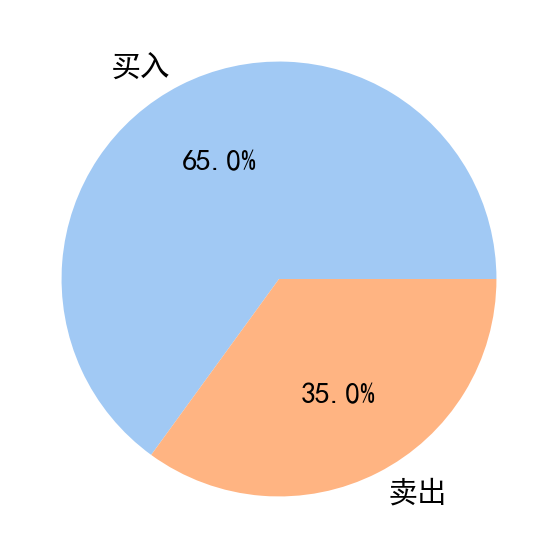

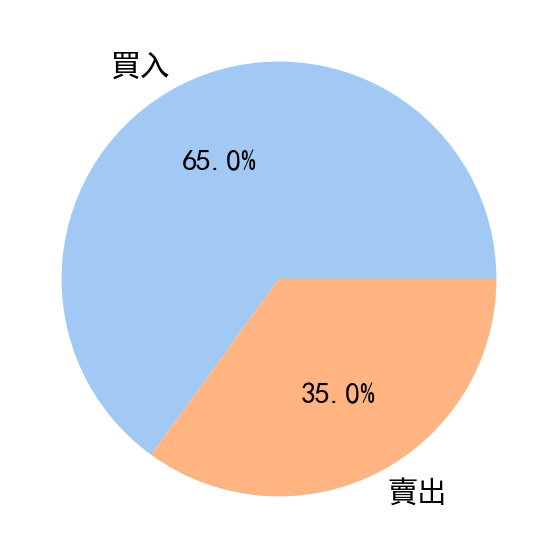

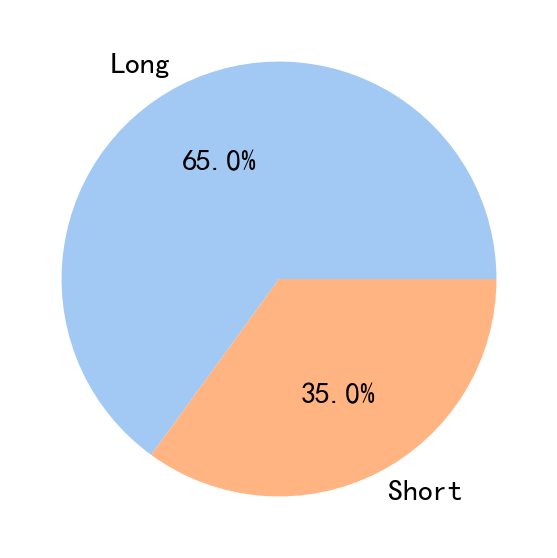

In [11]:
# BODY
# USCPI 12/13 21:30
# EIA 12/14 23:30
# EIA 12/21 23:30
# EIA 12/30 00:00
# GEPMI 12/16 16:30
# NF 12/02 21:30
# BOC 01/18 11:00(随时)
# BOC 01/25 23:00


deal= Trade_info()
print('等待交易开始')
# wait_trade(deal.code_start_time)
print('开始读取数据')

# 从sql库读取数据
sql_data= get_data_sql()

# 根据模型选择特定模式
m_c= model_customized(sql_data,deal.model_name)

# 处理sql和外部数据
feature= process_data(m_c,sql_data)

# 接收数据生成文字图片和报告
generate_pdf_body(m_c,feature,deal.model_name)
        
# 上传至url
# url_request('sim',feature)
# url_request('tra',feature)
# url_request('eng',feature)

# 发邮件
# sendEmail('sim', receiver="simaschu@goldriven.com", subject="report")
# sendEmail('tra', receiver="simaschu@goldriven.com", subject="report")
# sendEmail('eng', receiver="simaschu@goldriven.com", subject="report")